In [2]:
#Utils
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

#Data analysis
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

#Feature selection and modeling
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

#Reproducibility
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [3]:
#Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [4]:
X = train.iloc[:,:27]
y = train.iloc[:,-1]
X.shape , y.shape

((38546, 27), (38546,))

In [5]:
features = list(test.columns) #the input features. It doesn't have 'loan_defaulted column'.
TARGET = 'loan_defaulted'

In [6]:
#Identify all numerical columns
num_columns = list(test[features].select_dtypes(include=['int64','float64']).columns)
#Identify all categorical columns
cat_columns = list(test[features].select_dtypes(include=['bool','object']).columns)
len(num_columns) , len(cat_columns)

(20, 7)

In [7]:
num_columns

['unique_id',
 'loan_amount',
 'loan_manager_id',
 'asset_cost',
 'loan_to_asset_value_ratio',
 'asset_manufacturer_id',
 'applicant_age',
 'area_code',
 'credit_score',
 'new_loan_accounts_in_last_6_months',
 'overdue_accounts_in_last_6_months',
 'avg_account_age',
 'credit_history_length',
 'no_of_inquiries_in_last_month',
 'no_of_loan_accounts',
 'active_loan_accounts',
 'overdue_accounts',
 'existing_loan_balance',
 'total_disbursed_amount',
 'current_installment']

In [8]:
'''
Variance inflation factor
VIF quantifies how much a feature is correlated with other features.
A high VIF means the feature is redundant or highly collinear — this can hurt model performance, especially for linear models.
| VIF Value | Interpretation                |
| --------- | ----------------------------- |
| 1 – 5     | Generally OK ✅                |
| 5 – 10    | Moderate multicollinearity ⚠️ |
| > 10      | High multicollinearity 🚨     |
It helps you decide whether to drop or combine features before training a model (especially linear models like Logistic 
Regression).
Reducing multicollinearity can lead to more stable, interpretable models.
'''

'\nVariance inflation factor\nVIF quantifies how much a feature is correlated with other features.\nA high VIF means the feature is redundant or highly collinear — this can hurt model performance, especially for linear models.\n| VIF Value | Interpretation                |\n| --------- | ----------------------------- |\n| 1 – 5     | Generally OK ✅                |\n| 5 – 10    | Moderate multicollinearity ⚠️ |\n| > 10      | High multicollinearity 🚨     |\nIt helps you decide whether to drop or combine features before training a model (especially linear models like Logistic \nRegression).\nReducing multicollinearity can lead to more stable, interpretable models.\n'

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X[num_columns].values, i) for i in range(X[num_columns].shape[1])], 
          index=X[num_columns].columns)

unique_id                              3.8888
loan_amount                           10.9739
loan_manager_id                        3.3479
asset_cost                            15.1720
loan_to_asset_value_ratio             24.9782
asset_manufacturer_id                  7.3200
applicant_age                         17.0914
area_code                              3.2267
credit_score                           2.5519
new_loan_accounts_in_last_6_months     1.5477
overdue_accounts_in_last_6_months      1.2883
avg_account_age                        2.0135
credit_history_length                  2.6358
no_of_inquiries_in_last_month          1.4512
no_of_loan_accounts                    1.6264
active_loan_accounts                   1.8647
overdue_accounts                       1.4076
existing_loan_balance                  1.2786
total_disbursed_amount                 1.4620
current_installment                    1.1932
dtype: float64

In [10]:
num_columns.remove('loan_to_asset_value_ratio')

pd.Series([variance_inflation_factor(X[num_columns].values, i) for i in range(X[num_columns].shape[1])], 
          index=X[num_columns].columns)

unique_id                              3.8026
loan_amount                           10.3313
loan_manager_id                        3.3129
asset_cost                            13.5881
asset_manufacturer_id                  6.8950
applicant_age                         13.9473
area_code                              3.1761
credit_score                           2.5258
new_loan_accounts_in_last_6_months     1.5426
overdue_accounts_in_last_6_months      1.2824
avg_account_age                        2.0135
credit_history_length                  2.6298
no_of_inquiries_in_last_month          1.4458
no_of_loan_accounts                    1.6264
active_loan_accounts                   1.8645
overdue_accounts                       1.4018
existing_loan_balance                  1.2769
total_disbursed_amount                 1.4580
current_installment                    1.1932
dtype: float64

In [11]:
num_columns.remove('applicant_age')

pd.Series([variance_inflation_factor(X[num_columns].values, i) for i in range(X[num_columns].shape[1])], 
          index=X[num_columns].columns)

unique_id                              3.6993
loan_amount                            9.5216
loan_manager_id                        3.2561
asset_cost                            11.6749
asset_manufacturer_id                  6.5118
area_code                              3.1160
credit_score                           2.4894
new_loan_accounts_in_last_6_months     1.5416
overdue_accounts_in_last_6_months      1.2805
avg_account_age                        2.0135
credit_history_length                  2.6298
no_of_inquiries_in_last_month          1.4443
no_of_loan_accounts                    1.6259
active_loan_accounts                   1.8642
overdue_accounts                       1.4003
existing_loan_balance                  1.2764
total_disbursed_amount                 1.4563
current_installment                    1.1930
dtype: float64

In [12]:
num_columns.remove('asset_cost')

pd.Series([variance_inflation_factor(X[num_columns].values, i) for i in range(X[num_columns].shape[1])], 
          index=X[num_columns].columns)

unique_id                             3.5378
loan_amount                           7.7889
loan_manager_id                       3.1821
asset_manufacturer_id                 5.8509
area_code                             3.0316
credit_score                          2.4418
new_loan_accounts_in_last_6_months    1.5407
overdue_accounts_in_last_6_months     1.2805
avg_account_age                       2.0126
credit_history_length                 2.6247
no_of_inquiries_in_last_month         1.4442
no_of_loan_accounts                   1.6165
active_loan_accounts                  1.8539
overdue_accounts                      1.4003
existing_loan_balance                 1.2760
total_disbursed_amount                1.4563
current_installment                   1.1929
dtype: float64

In [13]:
num_columns.remove('loan_amount')

pd.Series([variance_inflation_factor(X[num_columns].values, i) for i in range(X[num_columns].shape[1])], 
          index=X[num_columns].columns)

unique_id                             3.2980
loan_manager_id                       3.0212
asset_manufacturer_id                 4.9108
area_code                             2.8983
credit_score                          2.3665
new_loan_accounts_in_last_6_months    1.5385
overdue_accounts_in_last_6_months     1.2804
avg_account_age                       2.0099
credit_history_length                 2.5988
no_of_inquiries_in_last_month         1.4428
no_of_loan_accounts                   1.6029
active_loan_accounts                  1.8411
overdue_accounts                      1.3987
existing_loan_balance                 1.2735
total_disbursed_amount                1.4547
current_installment                   1.1929
dtype: float64

In [14]:
'''
The F-score (F-statistic) in this context comes from ANOVA (Analysis of Variance) and is used to test whether
a numerical feature significantly explains variation in the target variable.

You're using f_classif(), which is a univariate feature selection test.
It tells you how strongly each numerical feature is associated with the target (loan_defaulted in this case).
You can remove irrelevant or weak features, which may improve performance and reduce overfitting.
f_classif() returns:
F-statistic: How much a feature influences the target
p-value: Probability the feature has no influence (null hypothesis)
Low p-values (< 0.05) indicate that the feature is statistically significant
accepted? = True: The feature is likely relevant to the prediction problem.
You might drop features with p-value > 0.05 (i.e., accepted? = False), especially if using simpler models.
'''

"\nThe F-score (F-statistic) in this context comes from ANOVA (Analysis of Variance) and is used to test whether\na numerical feature significantly explains variation in the target variable.\n\nYou're using f_classif(), which is a univariate feature selection test.\nIt tells you how strongly each numerical feature is associated with the target (loan_defaulted in this case).\nYou can remove irrelevant or weak features, which may improve performance and reduce overfitting.\nf_classif() returns:\nF-statistic: How much a feature influences the target\np-value: Probability the feature has no influence (null hypothesis)\nLow p-values (< 0.05) indicate that the feature is statistically significant\naccepted? = True: The feature is likely relevant to the prediction problem.\nYou might drop features with p-value > 0.05 (i.e., accepted? = False), especially if using simpler models.\n"

In [15]:
#Checking F-score
anova_test = f_classif(X[num_columns], y)

pd.DataFrame(
    data={
        'f-statistic': np.round(anova_test[0],decimals=5), 
        'p-value': np.round(anova_test[1],decimals=4),
        'accepted?': anova_test[1] < 0.05
    },
    index=num_columns
)

,f-statistic,p-value,accepted?
unique_id,0.0779,0.7802,False
loan_manager_id,127.9498,0.0000,True
asset_manufacturer_id,93.2870,0.0000,True
area_code,6.0589,0.0138,True
credit_score,16.2772,0.0001,True
new_loan_accounts_in_last_6_months,978.0804,0.0000,True
overdue_accounts_in_last_6_months,858.1443,0.0000,True
avg_account_age,778.1300,0.0000,True
credit_history_length,1112.7640,0.0000,True
no_of_inquiries_in_last_month,837.2846,0.0000,True


In [16]:
num_columns.remove('unique_id')
num_columns.remove('loan_manager_id')

In [17]:
anova_test = f_classif(X[num_columns], y)

pd.DataFrame(
    data={
        'f-statistic': np.round(anova_test[0],decimals=5), 
        'p-value': np.round(anova_test[1],decimals=4),
        'accepted?': anova_test[1] < 0.05
    },
    index=num_columns
)

,f-statistic,p-value,accepted?
asset_manufacturer_id,93.2870,0.0000,True
area_code,6.0589,0.0138,True
credit_score,16.2772,0.0001,True
new_loan_accounts_in_last_6_months,978.0804,0.0000,True
overdue_accounts_in_last_6_months,858.1443,0.0000,True
avg_account_age,778.1300,0.0000,True
credit_history_length,1112.7640,0.0000,True
no_of_inquiries_in_last_month,837.2846,0.0000,True
no_of_loan_accounts,186.7488,0.0000,True
active_loan_accounts,797.1270,0.0000,True


In [18]:
num_columns

['asset_manufacturer_id',
 'area_code',
 'credit_score',
 'new_loan_accounts_in_last_6_months',
 'overdue_accounts_in_last_6_months',
 'avg_account_age',
 'credit_history_length',
 'no_of_inquiries_in_last_month',
 'no_of_loan_accounts',
 'active_loan_accounts',
 'overdue_accounts',
 'existing_loan_balance',
 'total_disbursed_amount',
 'current_installment']

In [19]:
cat_columns

['employment_type',
 'mobile_no_available',
 'aadhaar_available',
 'pan_available',
 'voter_id_available',
 'driving_licence_available',
 'passport_available']

In [20]:
print(train[cat_columns].dtypes)

employment_type              object
mobile_no_available            bool
aadhaar_available              bool
pan_available                  bool
voter_id_available             bool
driving_licence_available      bool
passport_available             bool
dtype: object


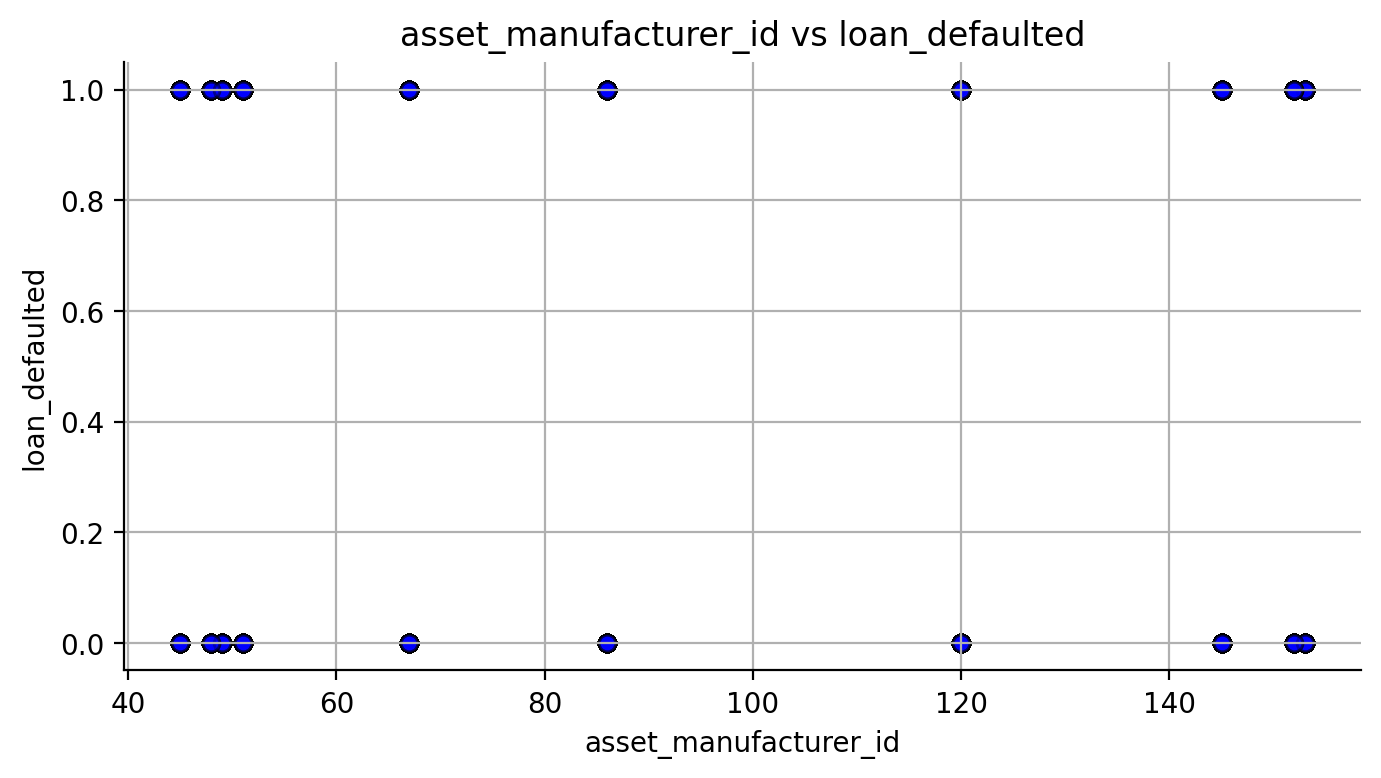

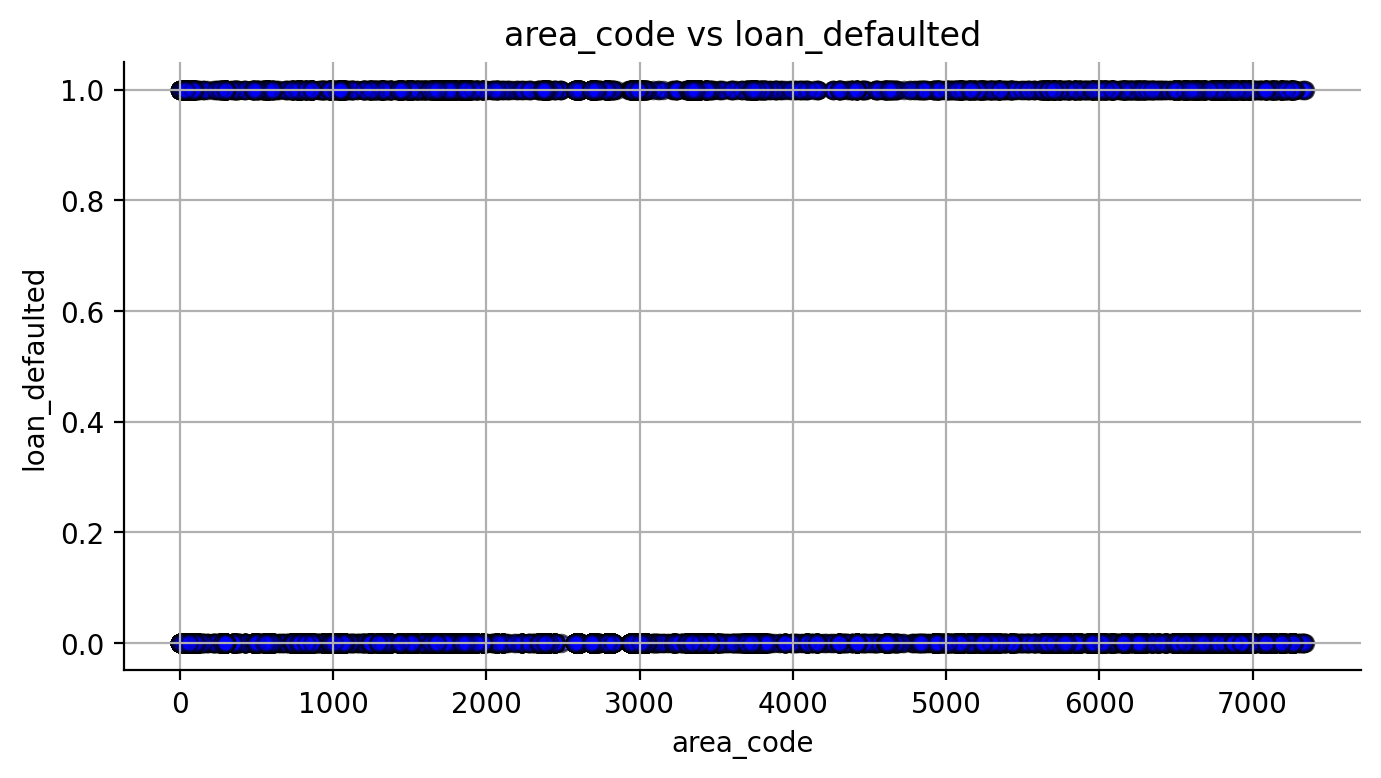

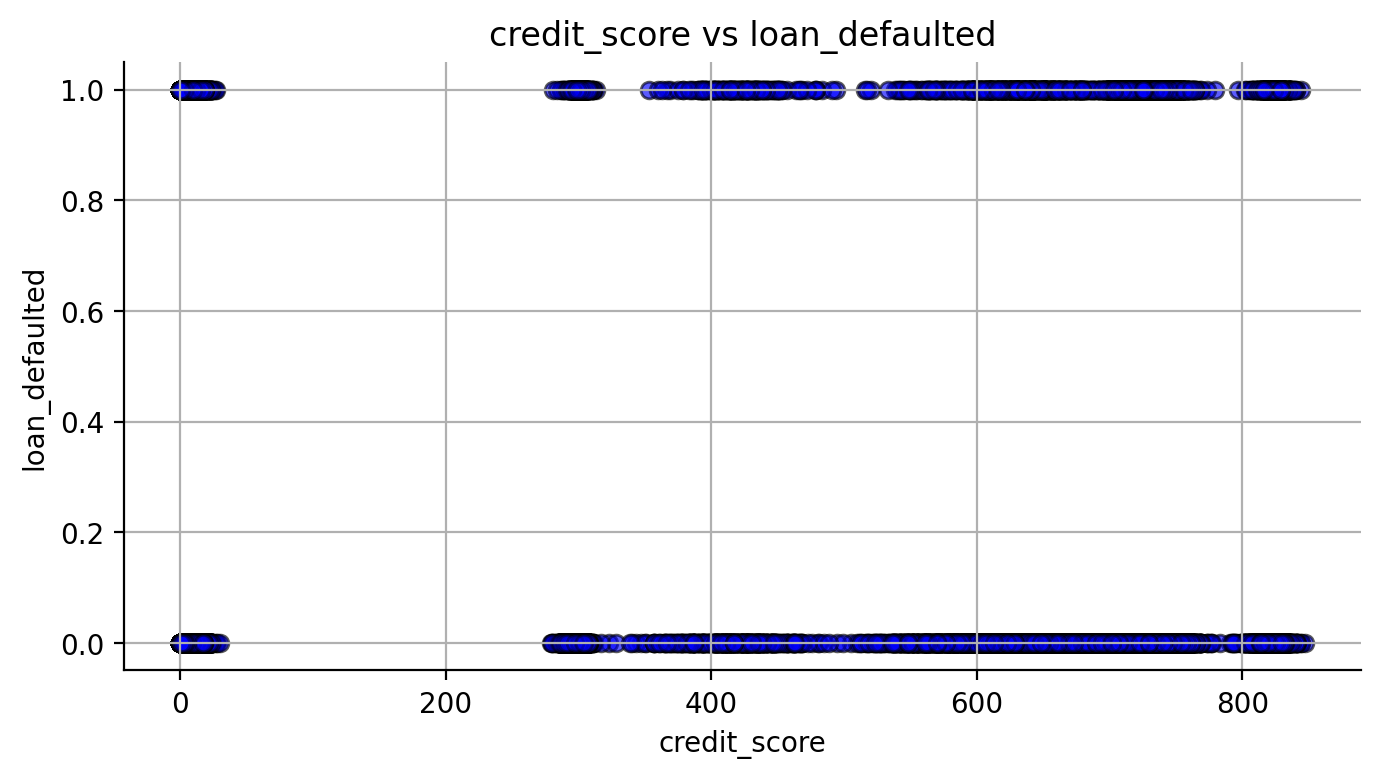

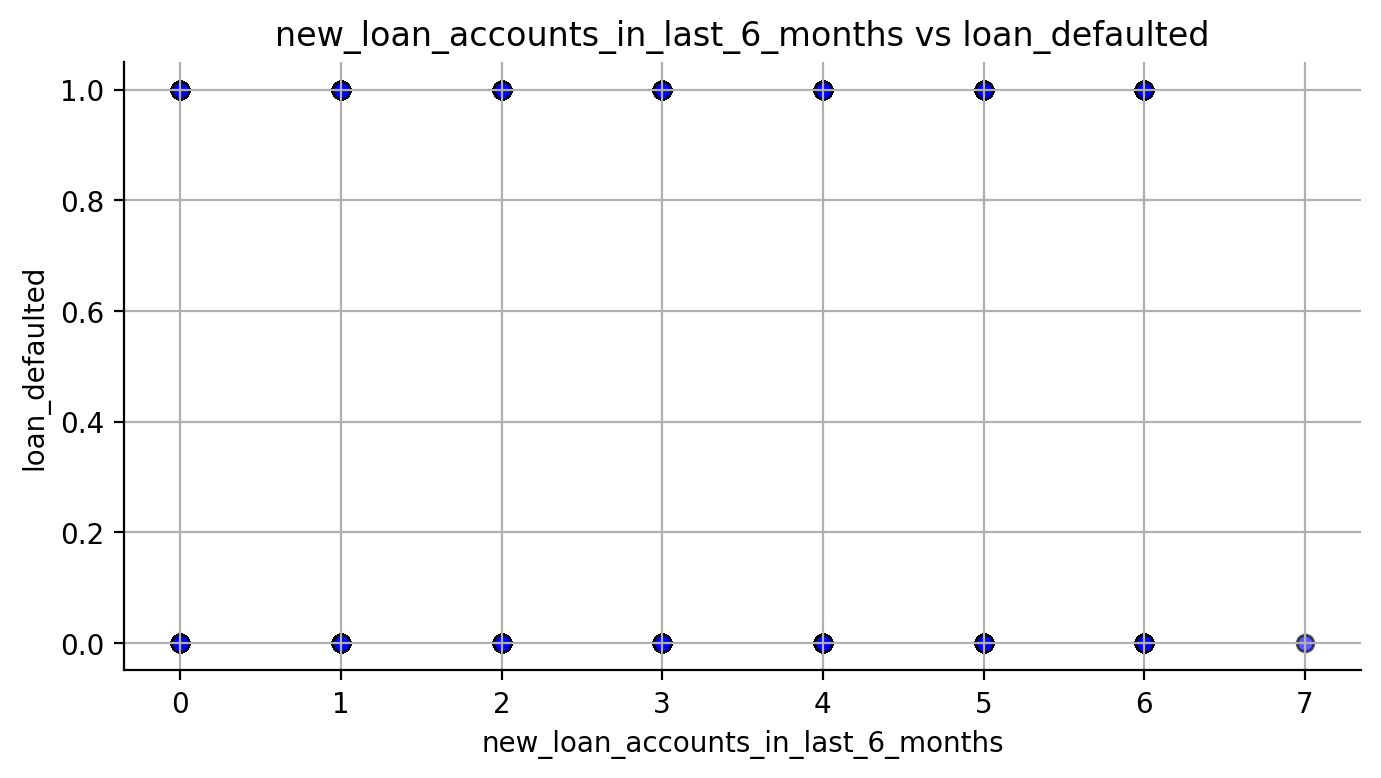

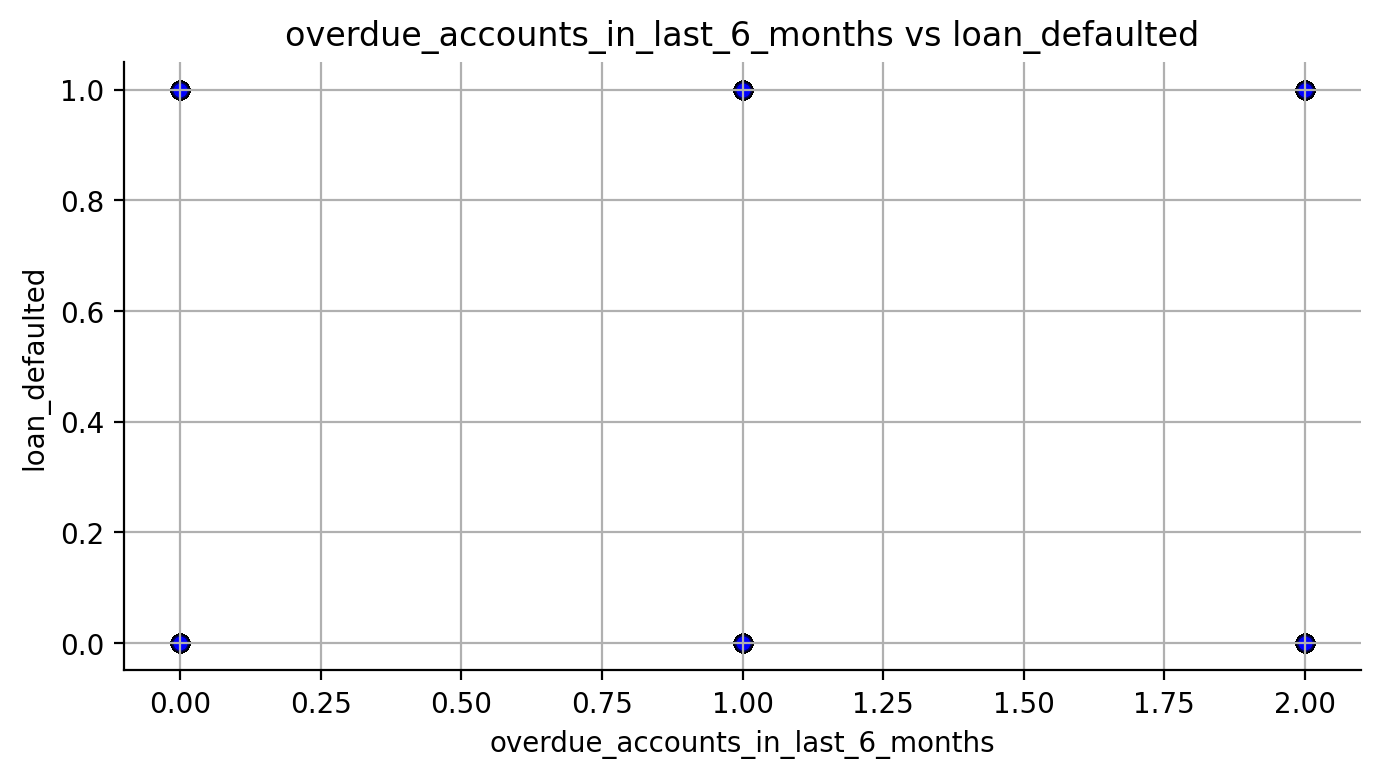

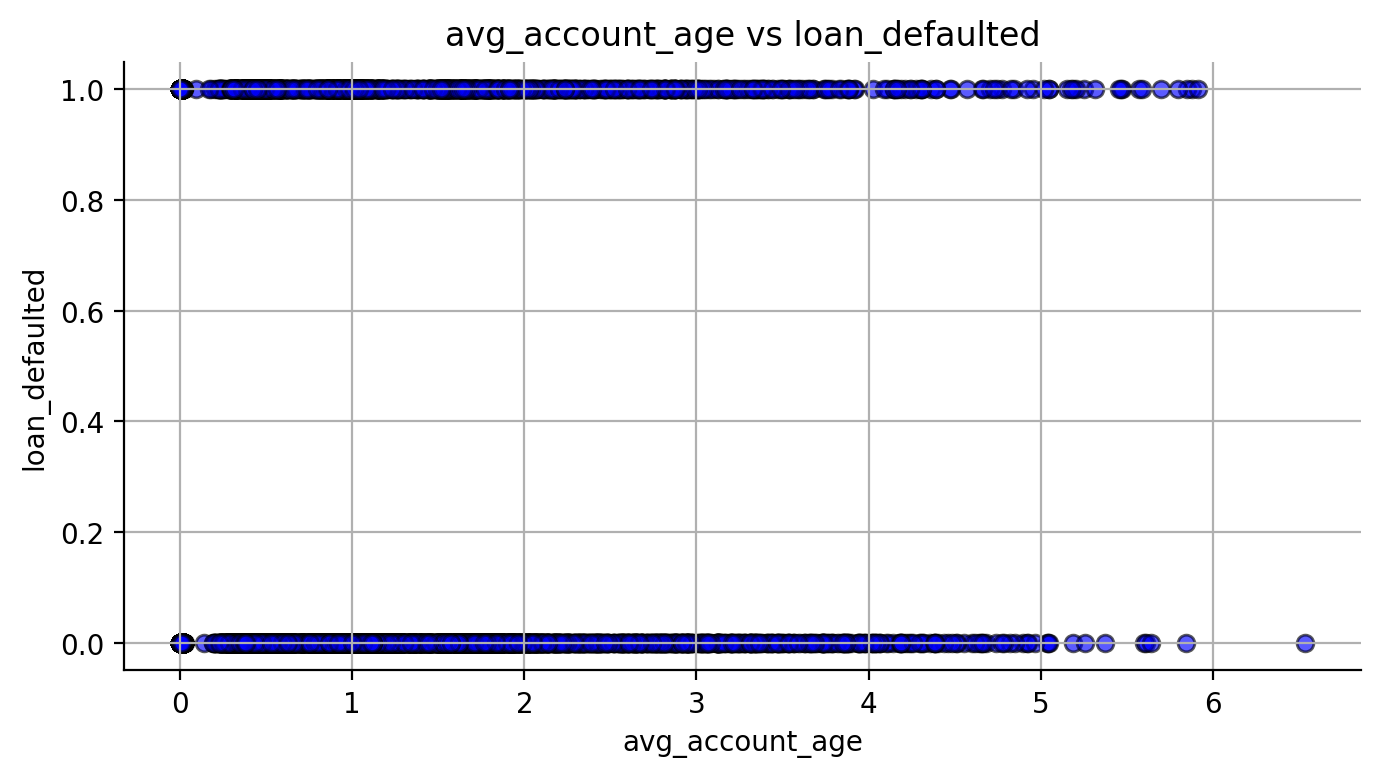

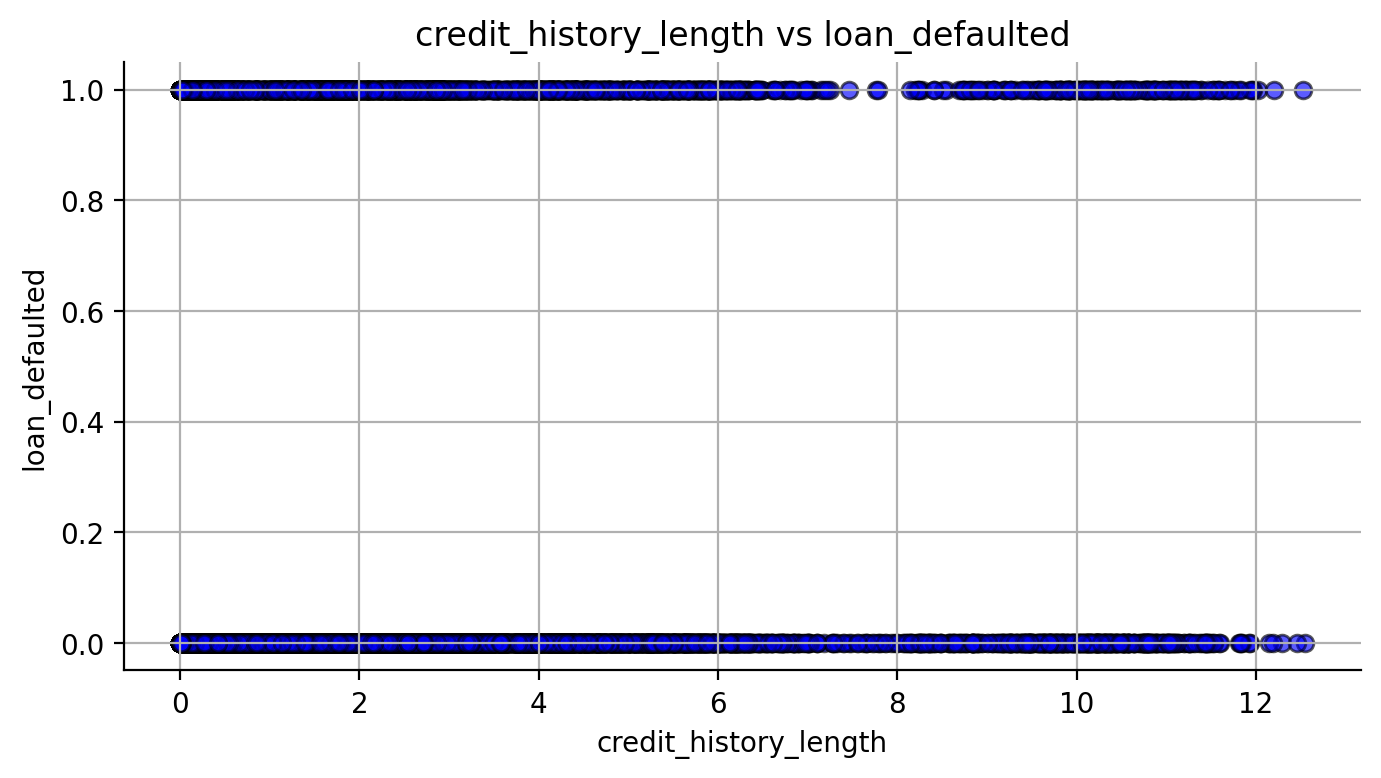

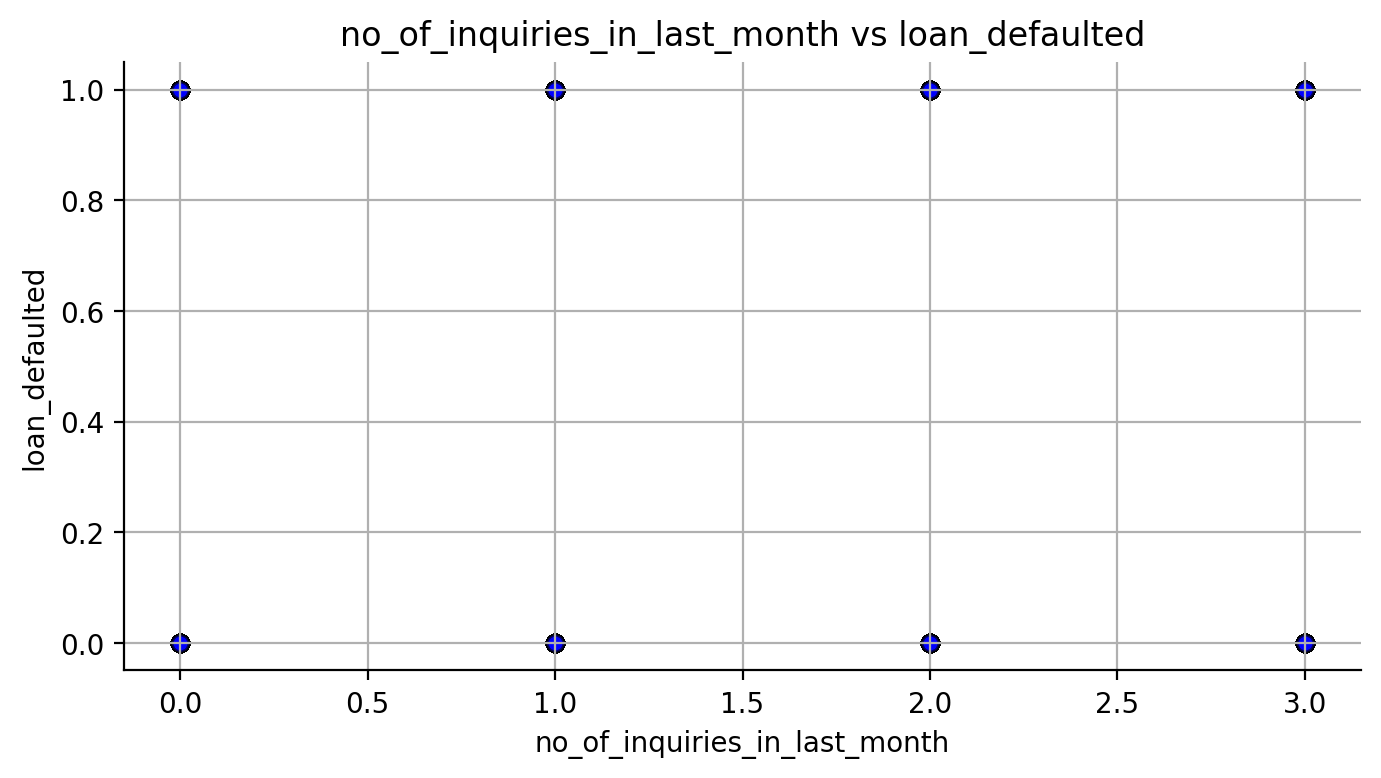

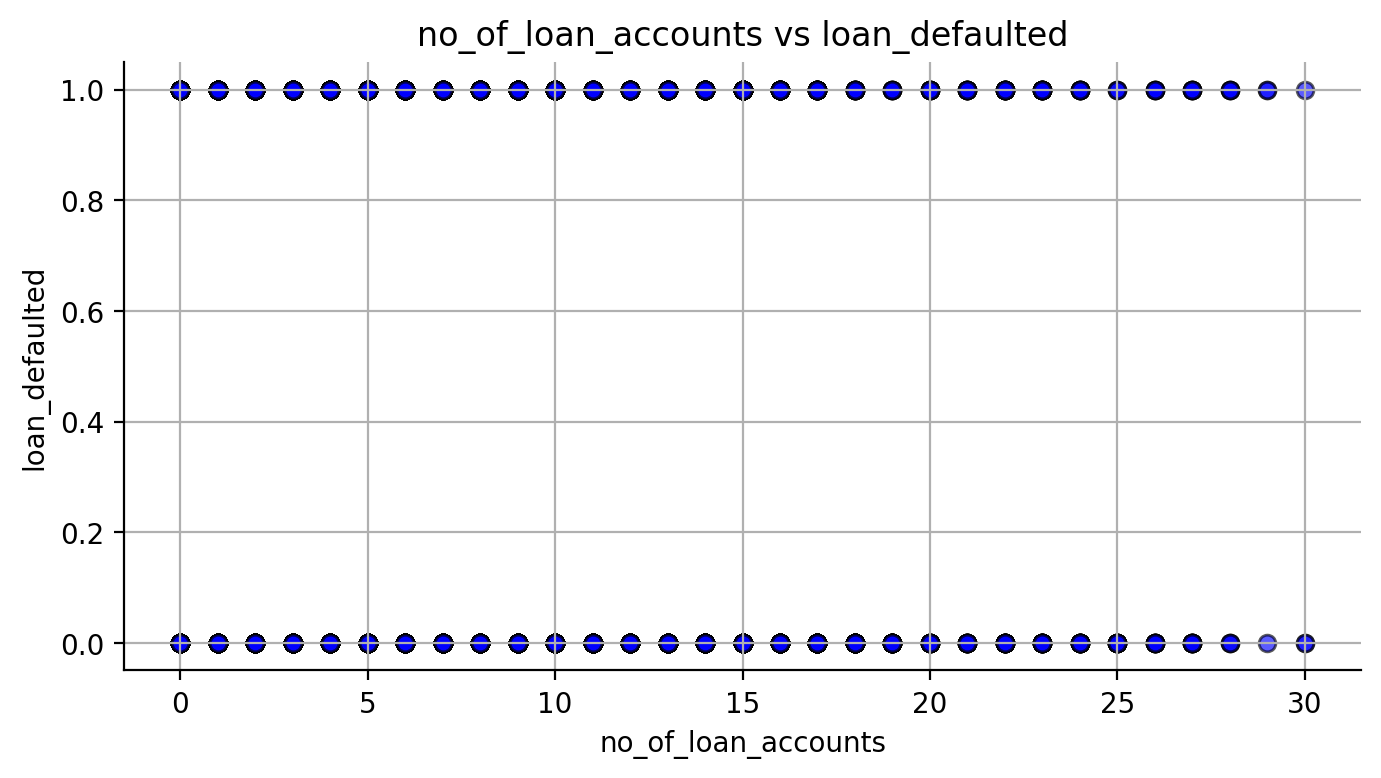

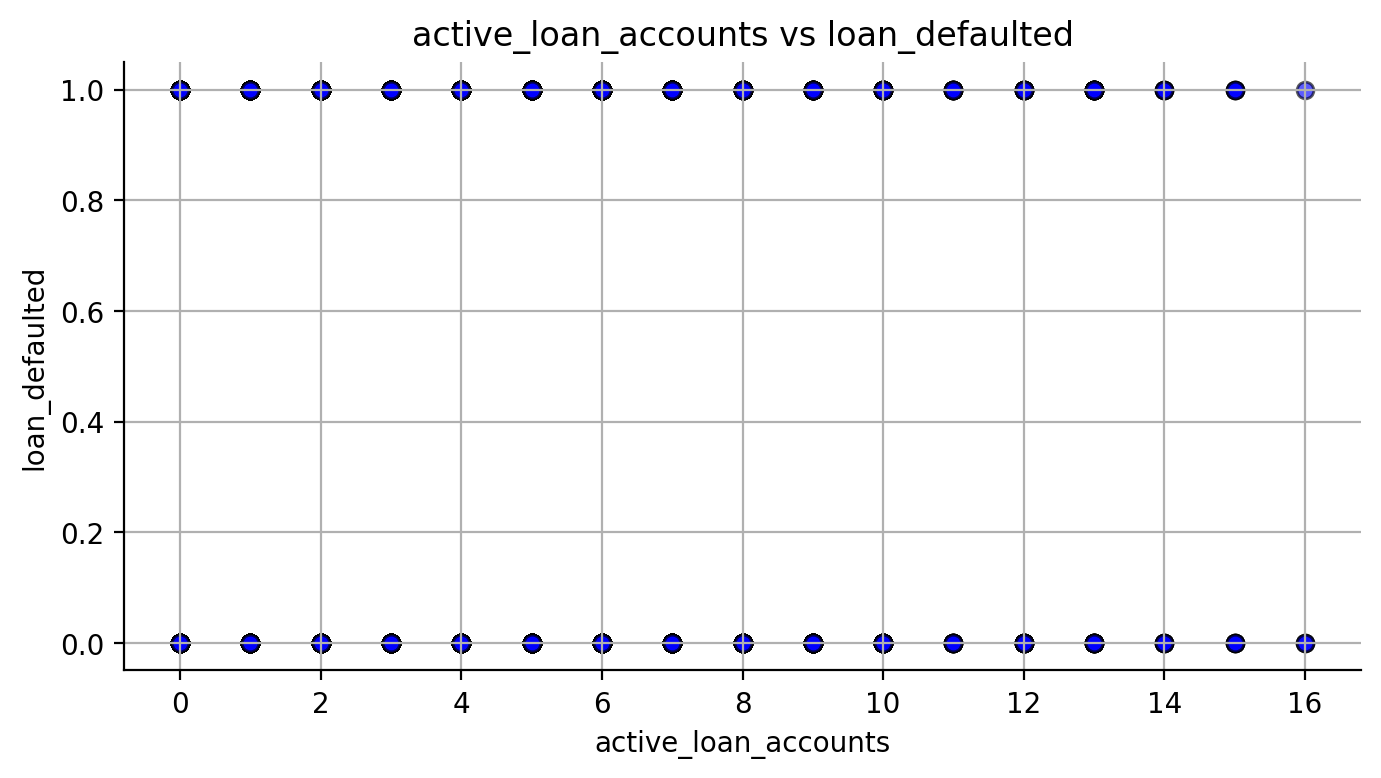

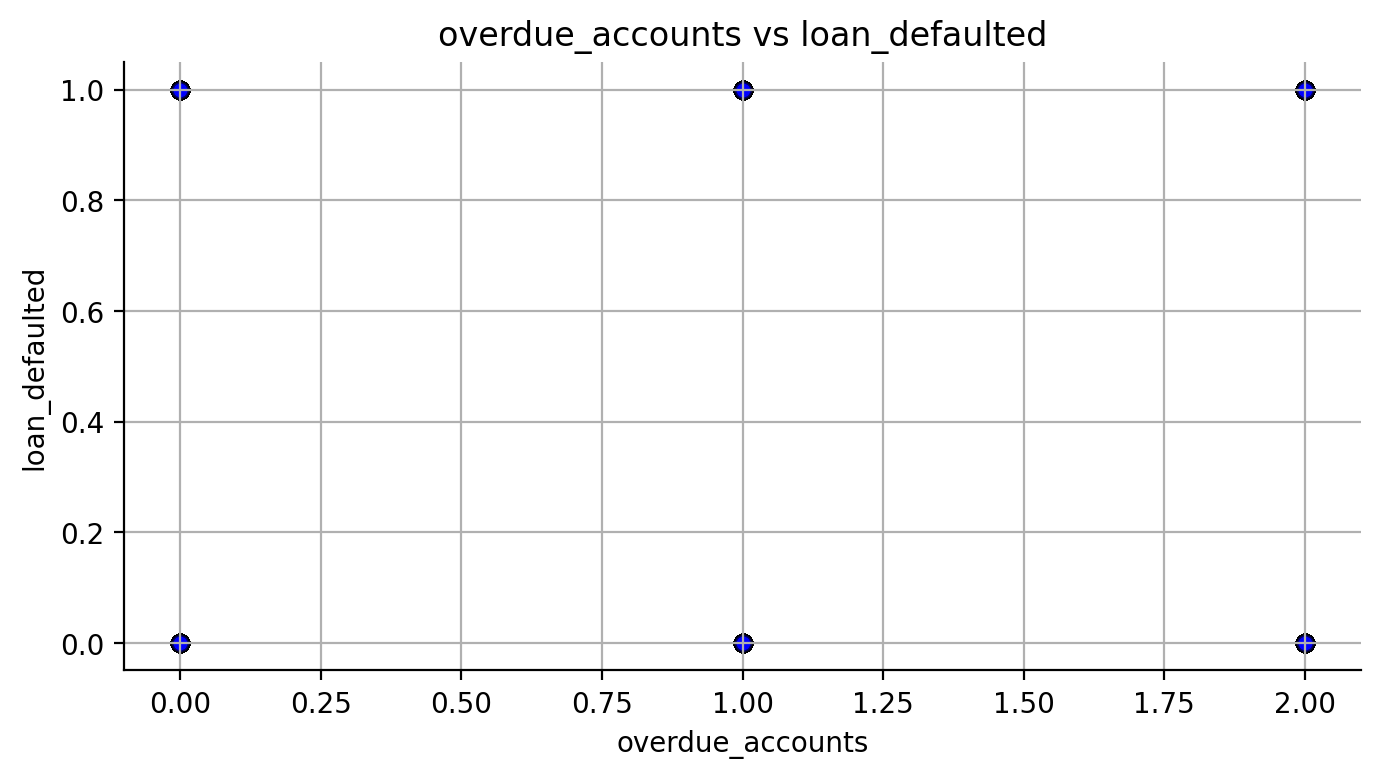

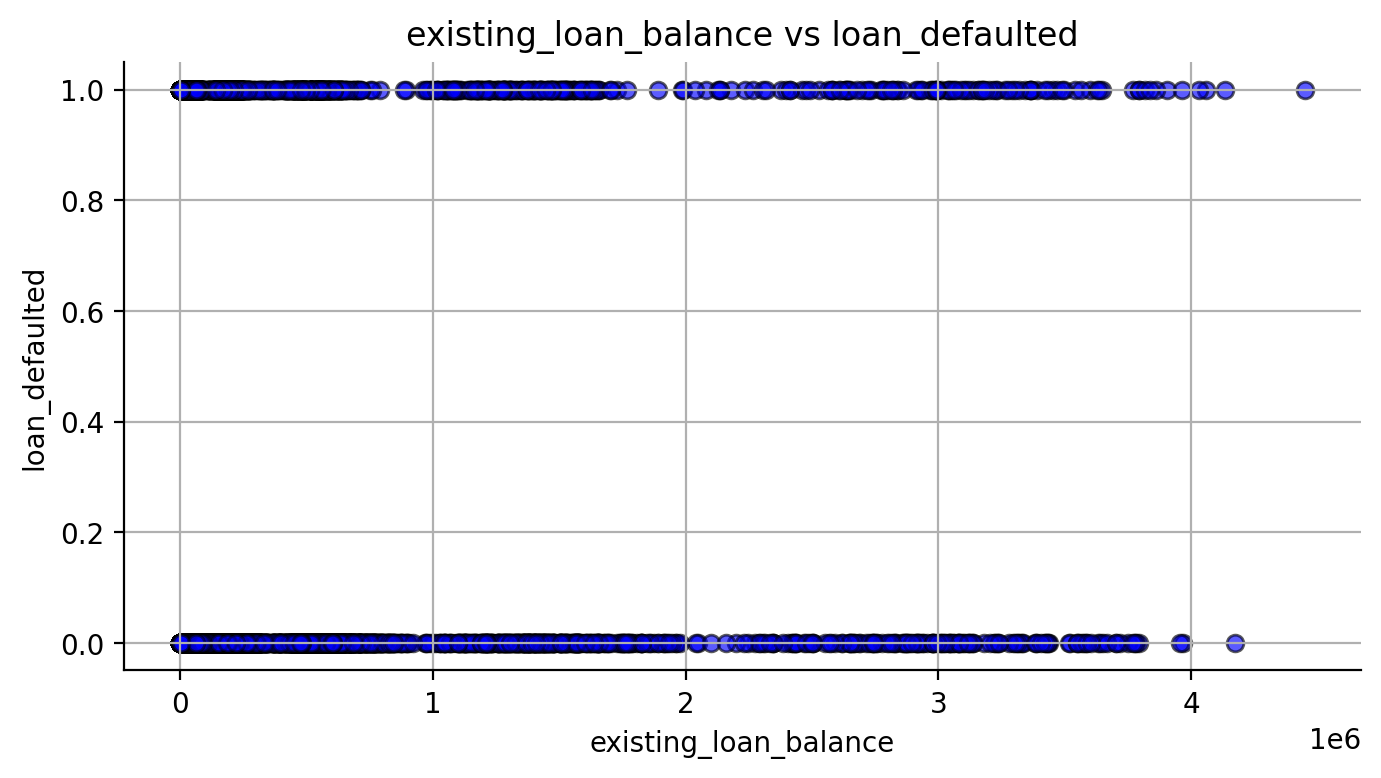

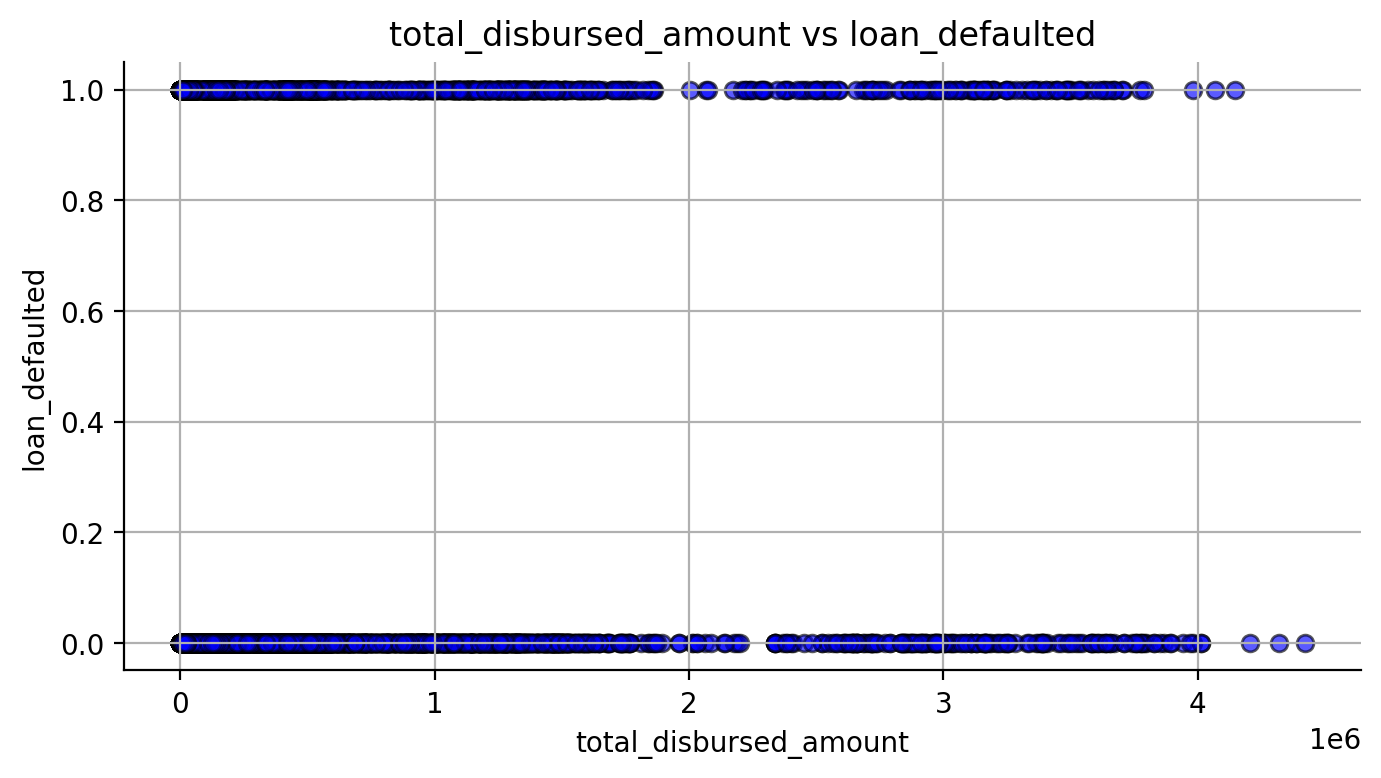

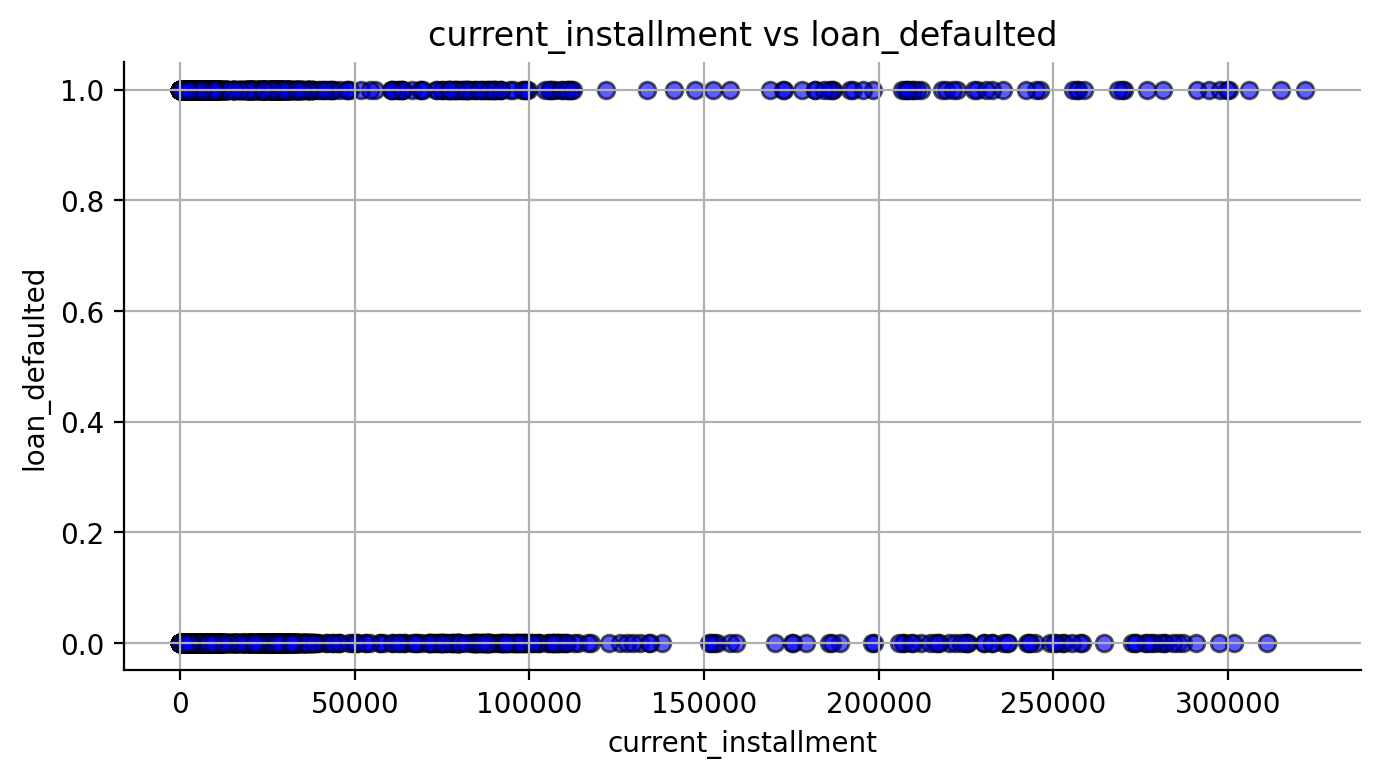

In [21]:
import matplotlib.pyplot as plt

# List of numerical features to visualize
target = 'loan_defaulted'

# Loop through each feature and plot it against the target
for feature in num_columns:
    plt.figure(figsize=(7, 4))
    plt.scatter(train[feature], train[target], alpha=0.4, c='blue', edgecolors='k')
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

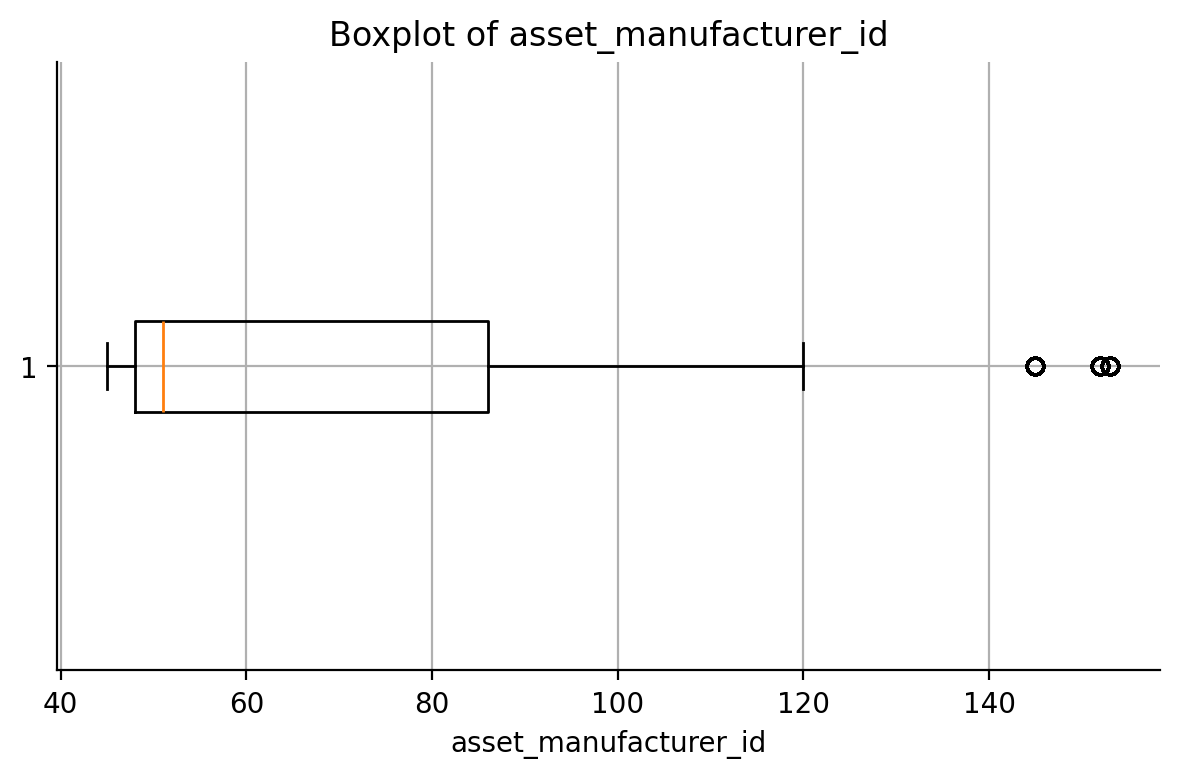

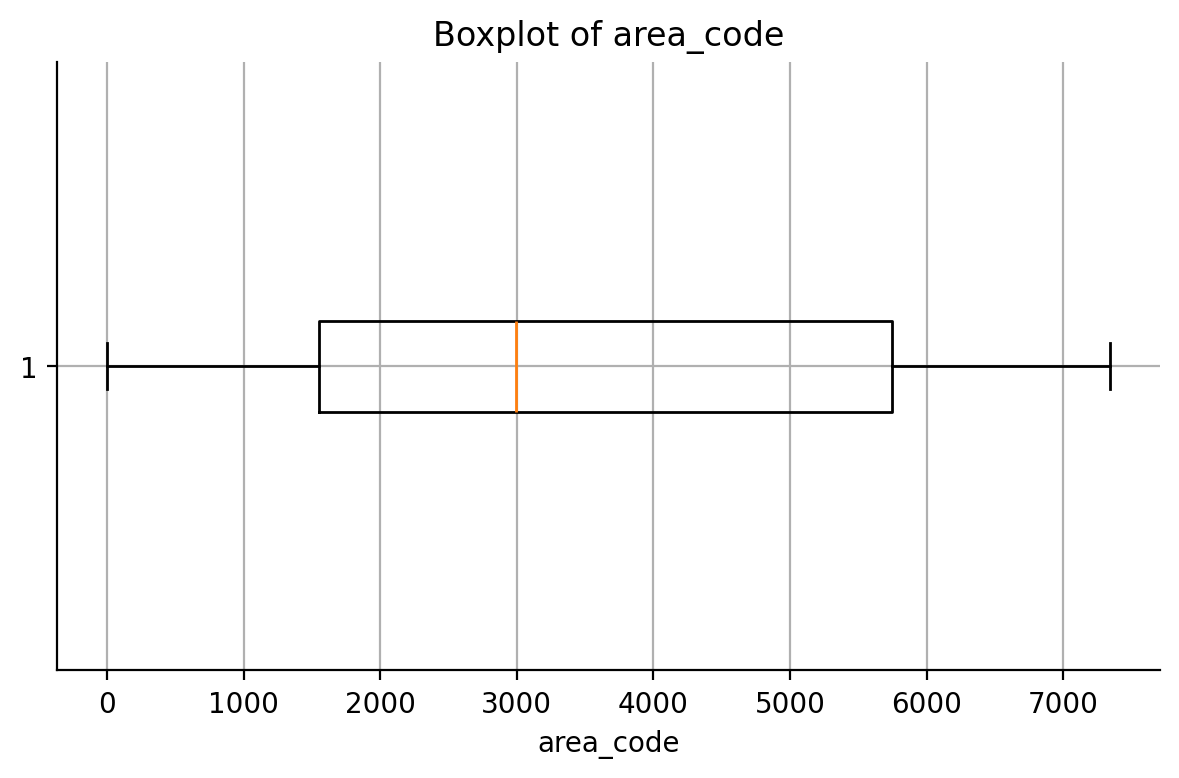

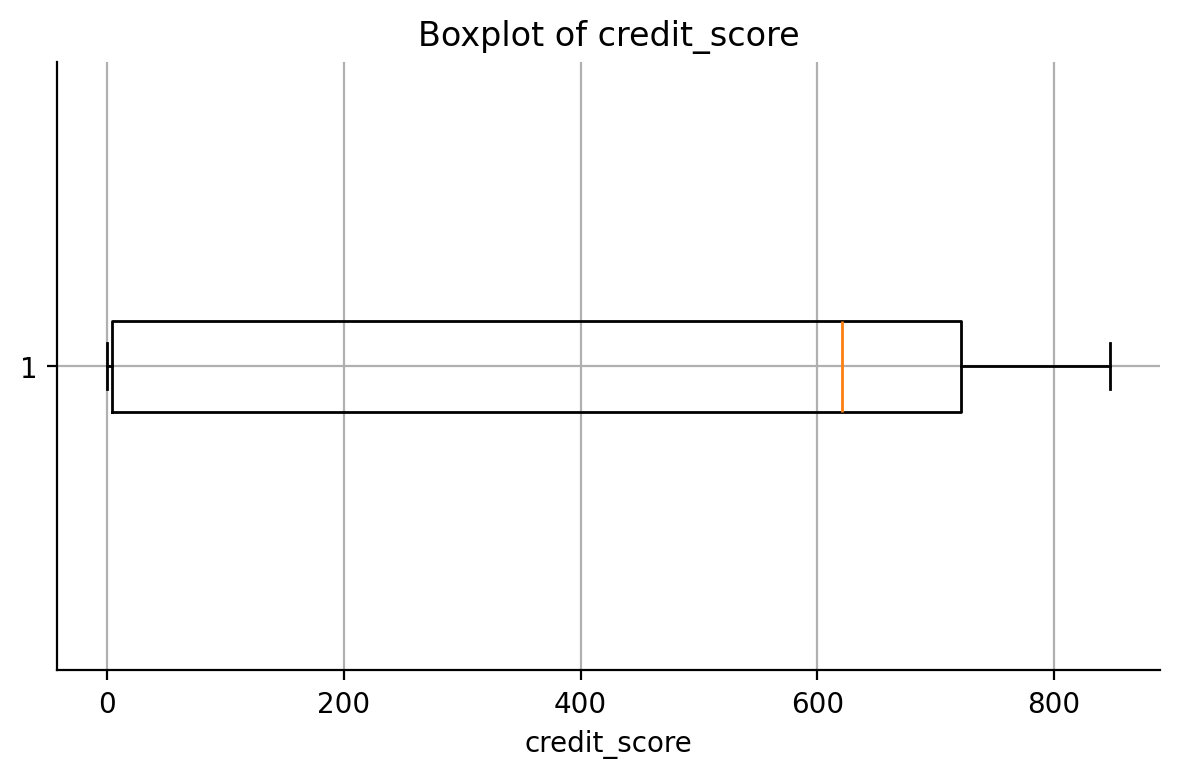

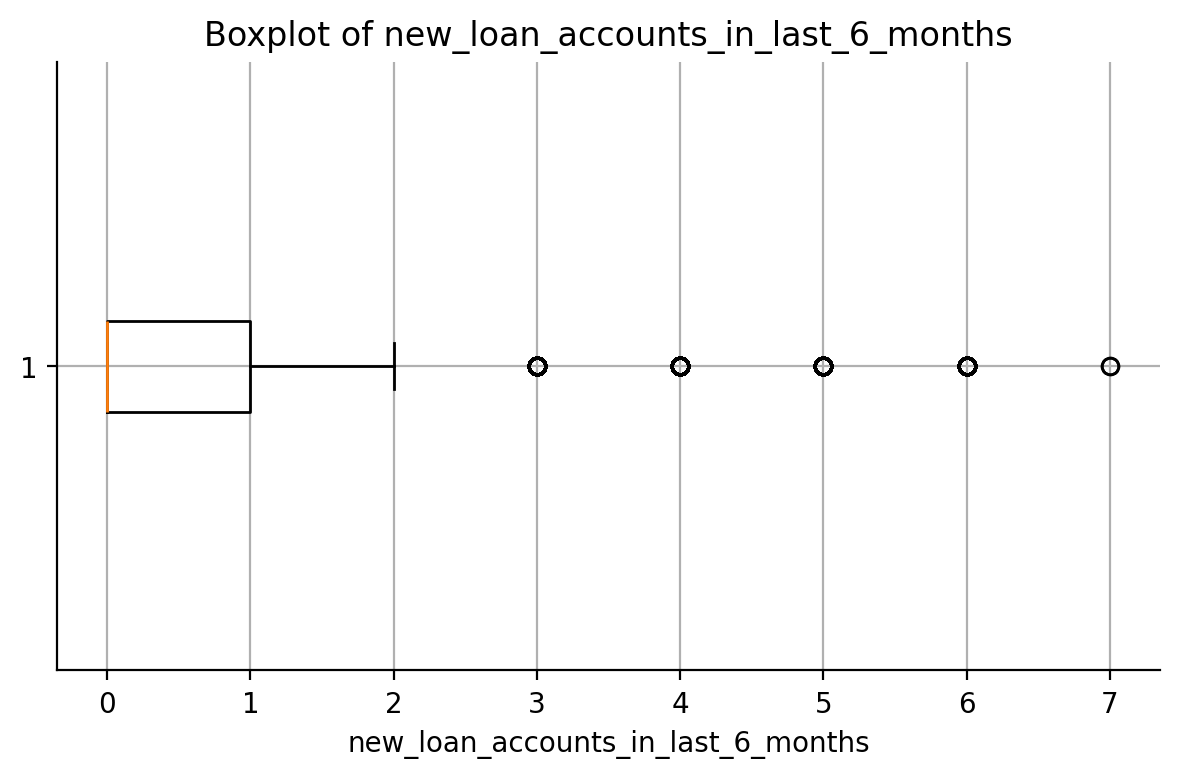

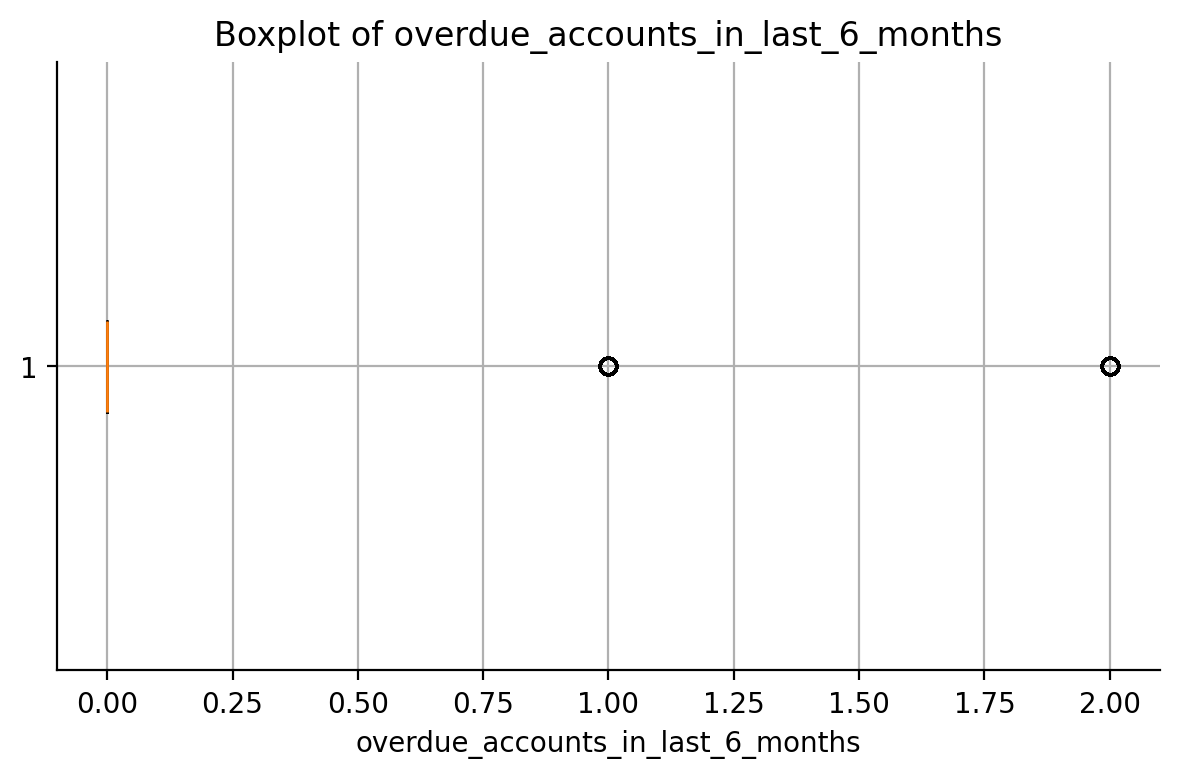

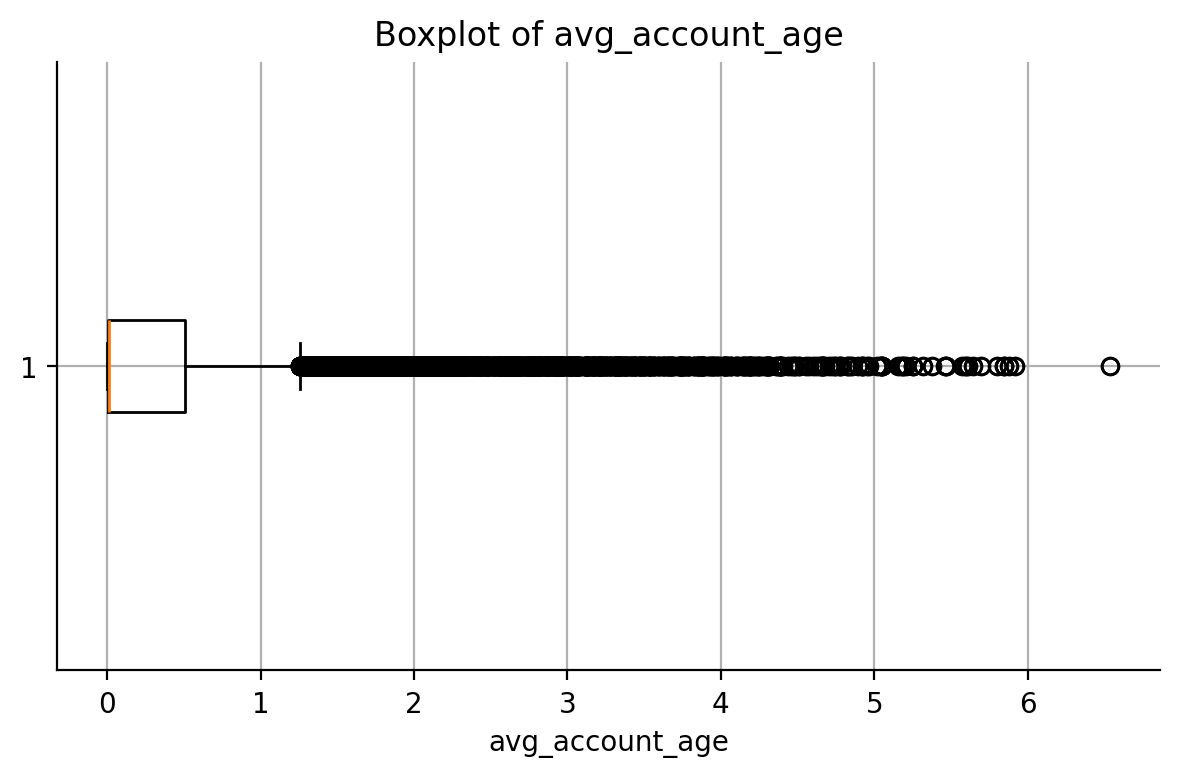

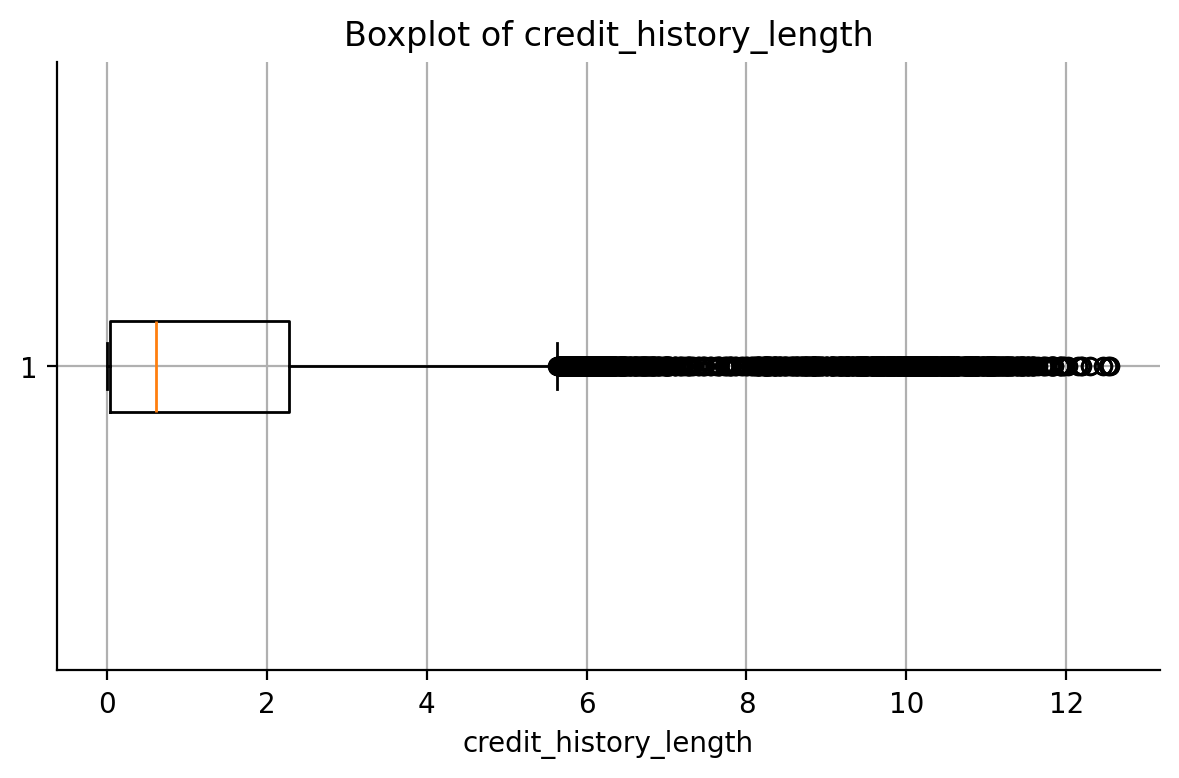

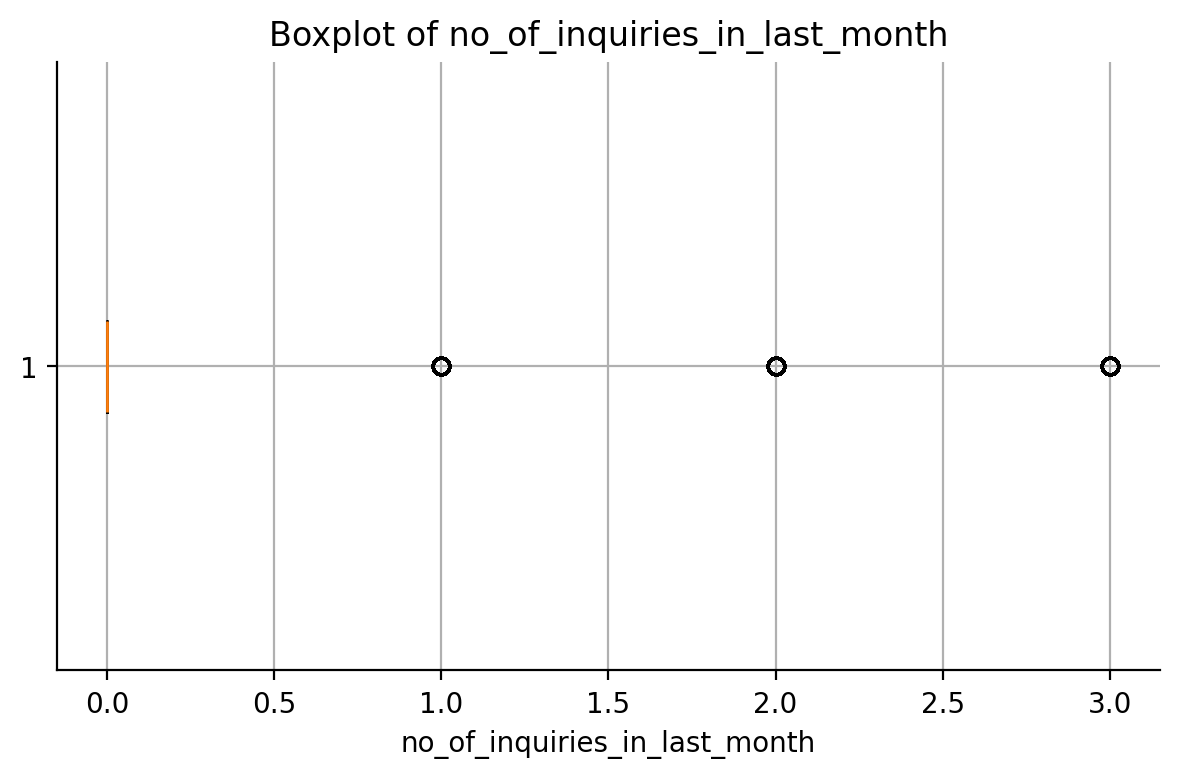

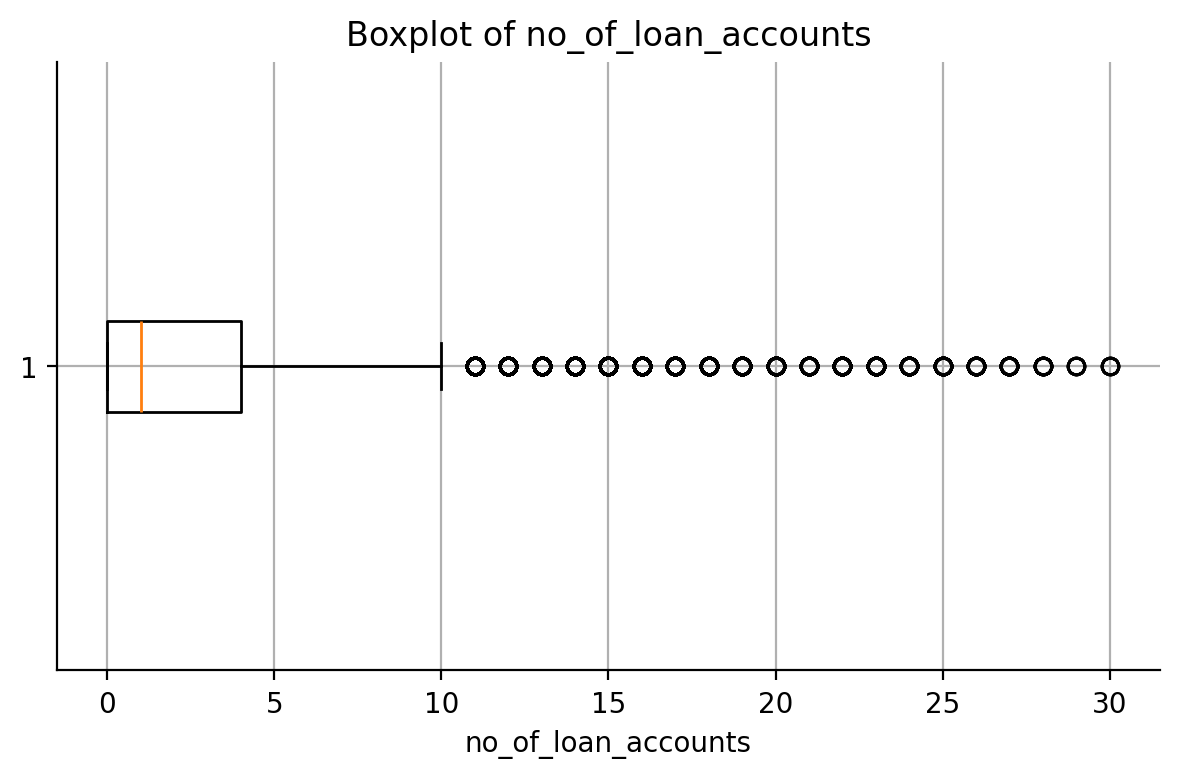

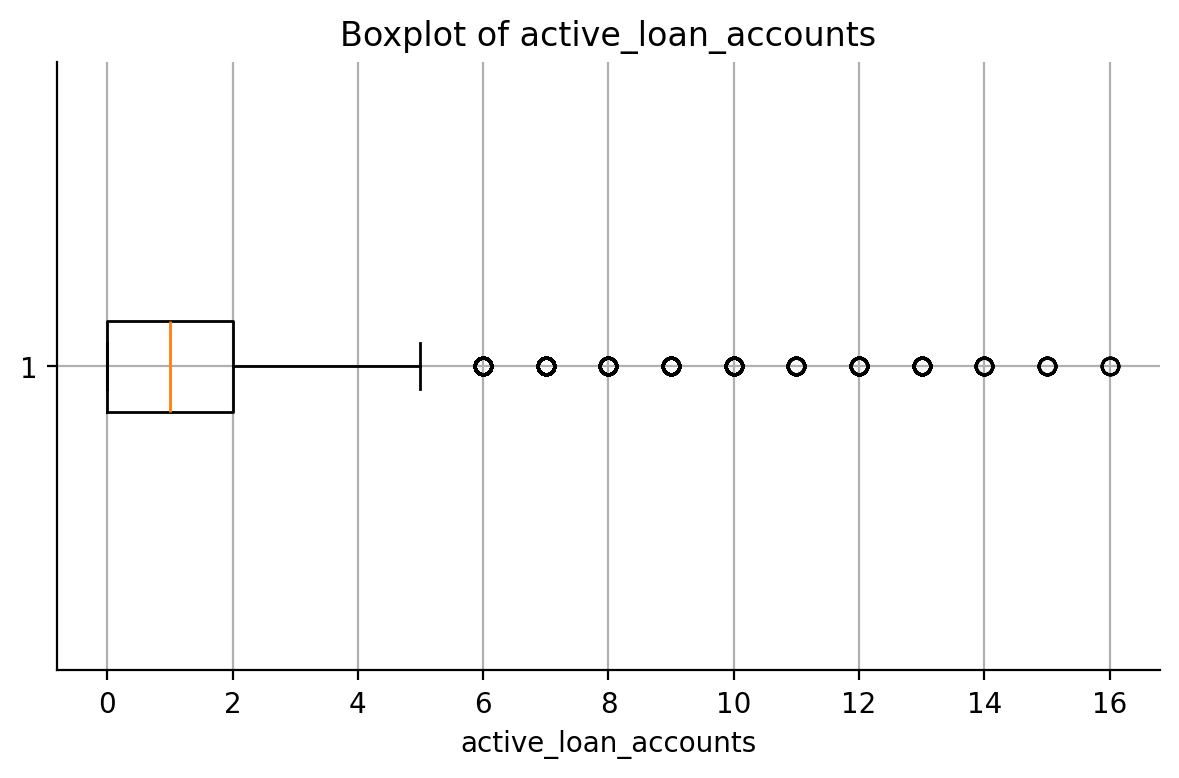

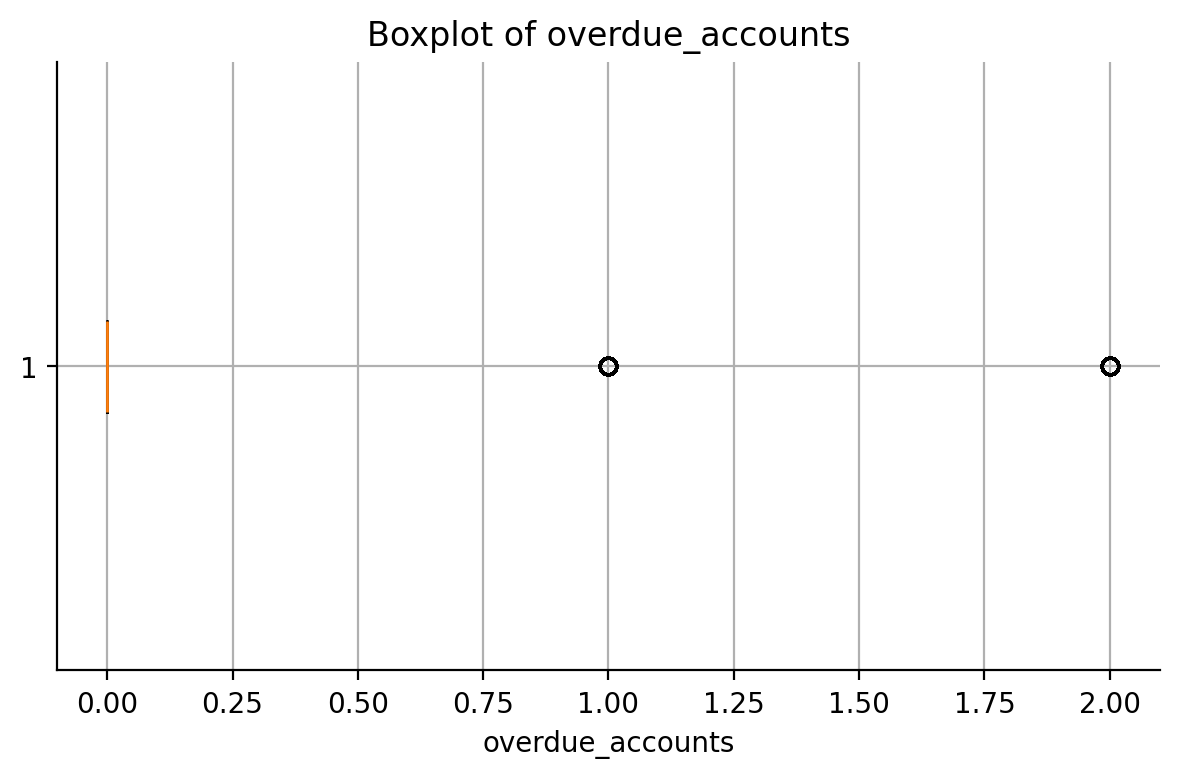

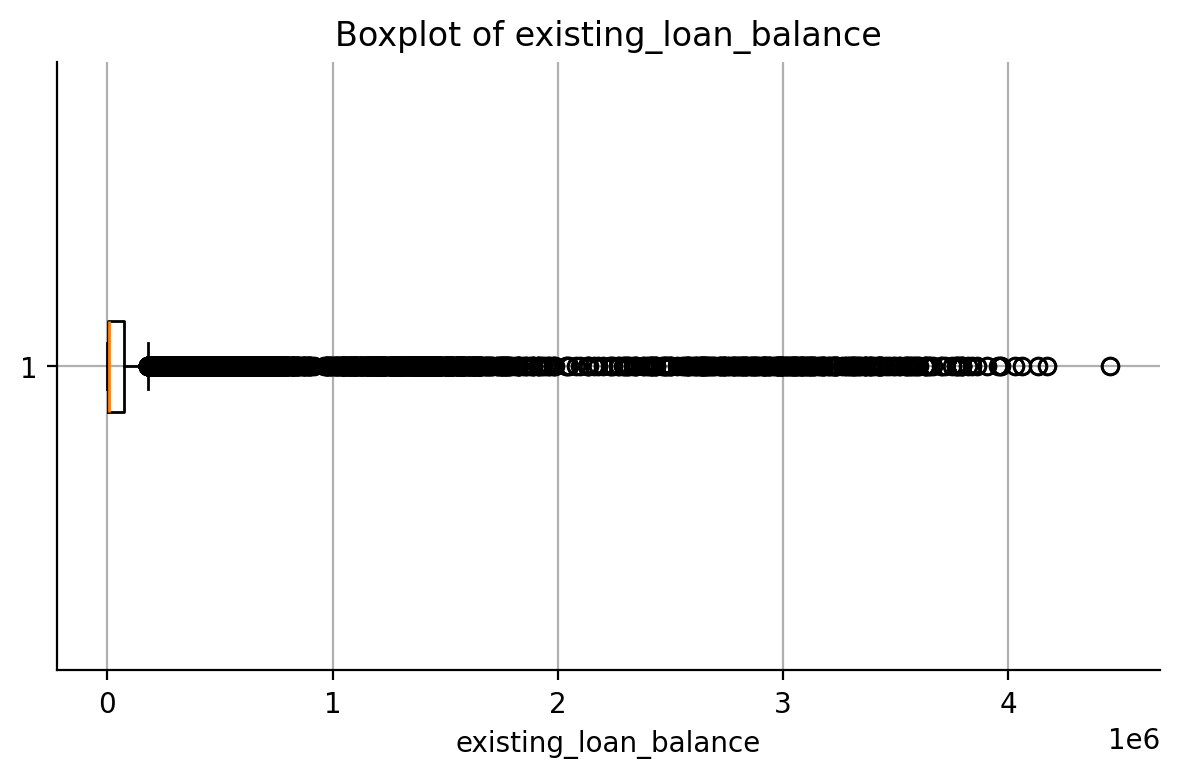

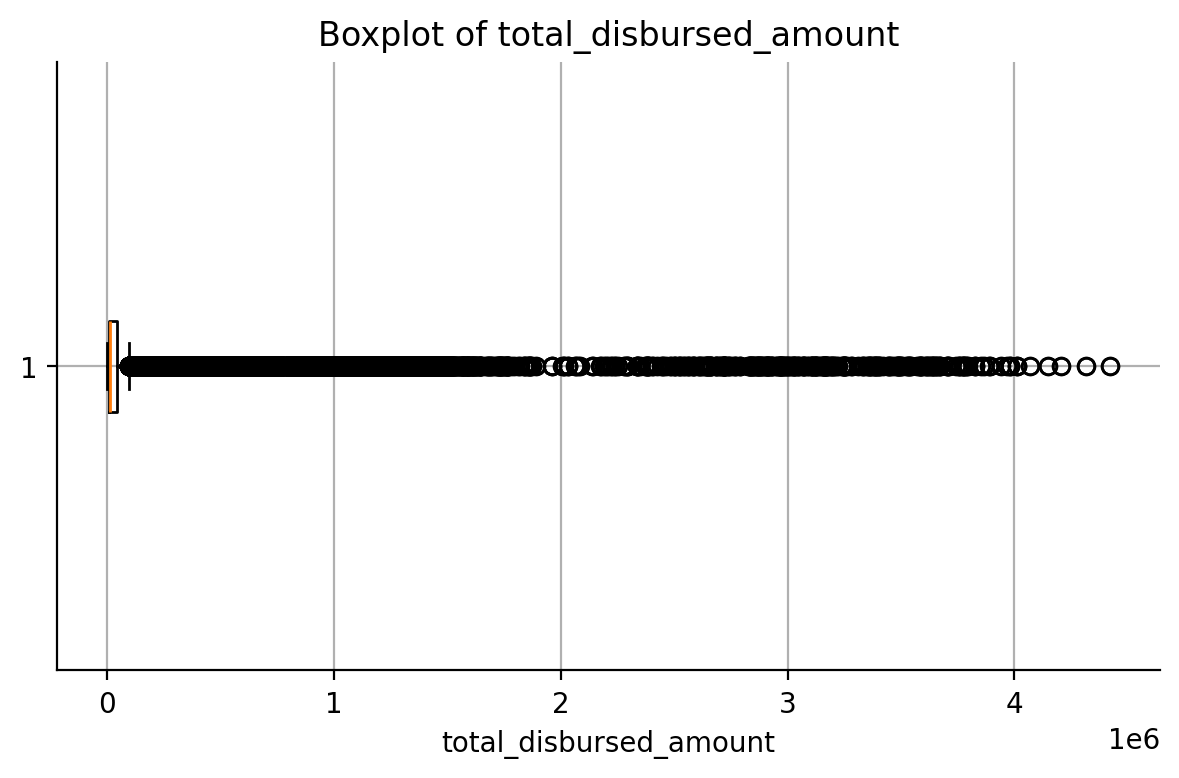

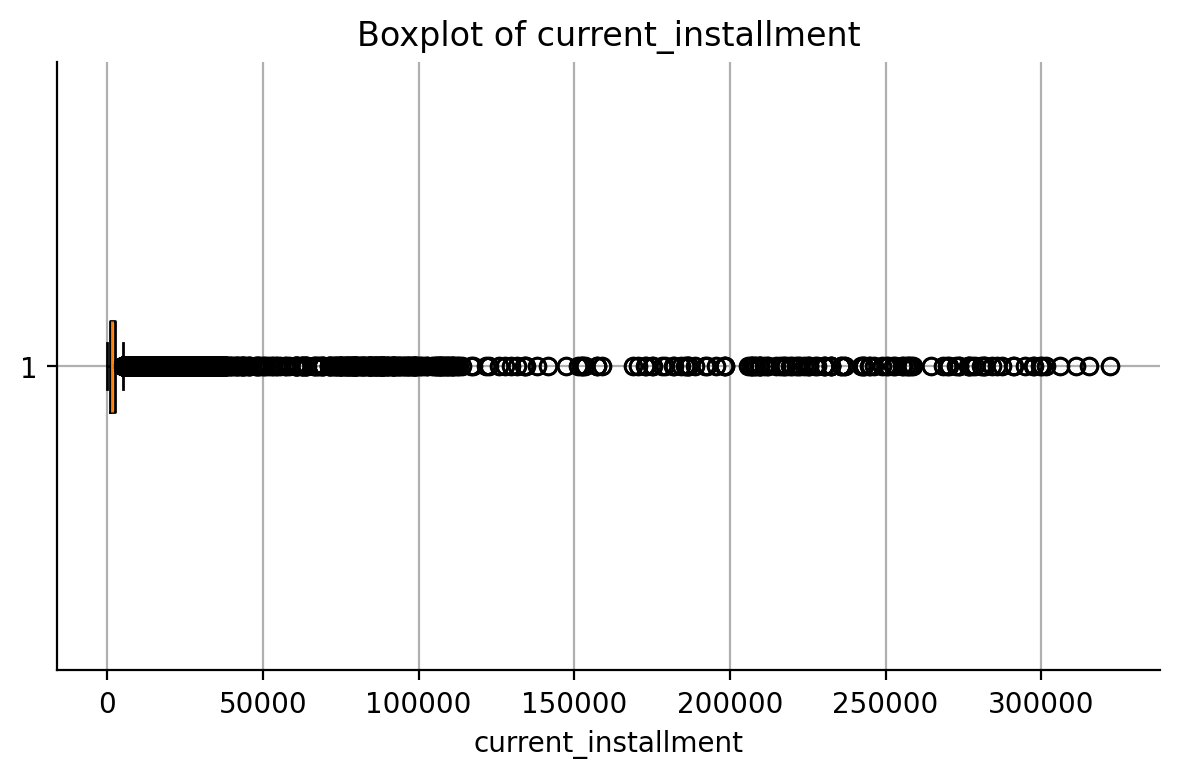

In [22]:
for col in num_columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(train[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
from scipy.stats import zscore
# Compute Z-scores
z_scores = train[num_columns].apply(zscore)

# Flag rows where any z-score is > 3 or < -3
outliers = train[(z_scores > 3).any(axis=1)]
print(f"Total outliers (Z-score > 3): {len(outliers)}")

Total outliers (Z-score > 3): 6708


In [24]:
train

,unique_id,loan_amount,loan_manager_id,asset_cost,loan_to_asset_value_ratio,asset_manufacturer_id,applicant_age,area_code,employment_type,mobile_no_available,aadhaar_available,pan_available,voter_id_available,driving_licence_available,passport_available,credit_score,new_loan_accounts_in_last_6_months,overdue_accounts_in_last_6_months,avg_account_age,credit_history_length,no_of_inquiries_in_last_month,no_of_loan_accounts,active_loan_accounts,overdue_accounts,existing_loan_balance,total_disbursed_amount,current_installment,loan_defaulted
0,0,63849,864,68552,72.9821,45,39,778,Self employed,True,True,False,False,False,False,18,0,0,0.0034,0.0123,0,0,0,0,3494,715120,856,False
1,1,41184,1192,67662,85.8347,45,45,4,Salaried,True,True,False,False,False,False,1,0,0,0.0044,0.0157,0,3,1,0,4784,7147,902,True
2,2,68313,2113,67793,75.7597,86,44,18,Self employed,True,True,False,False,False,False,719,0,0,0.0115,0.0289,0,0,1,0,8764,11188,1219,False
3,3,61636,1139,68504,73.3643,45,27,2448,Self employed,True,True,True,False,False,False,1,0,0,0.0118,0.5507,0,28,0,0,81808,5932,1159,False
4,4,51532,2455,65369,43.9204,86,27,6276,Self employed,True,True,False,False,False,False,757,1,0,0.4154,3.3592,1,0,3,1,322731,3033357,8196,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38541,38541,40434,54,99210,75.4034,51,37,3340,Self employed,True,True,False,True,False,False,2,0,0,0.0011,1.7753,1,1,1,0,62519,5285,1269,False
38542,38542,41293,854,70186,77.4211,86,33,3005,Salaried,True,True,False,False,False,False,613,0,0,0.0086,0.2651,0,2,0,0,221733,6480,2009,False
38543,38543,58229,352,66830,54.6371,45,35,2578,Self employed,True,True,False,False,False,False,3,0,0,0.0020,0.0118,0,5,0,0,329824,14741,2795,False
38544,38544,63852,227,100958,82.1896,86,25,2708,Self employed,True,False,False,False,False,False,725,0,0,0.0014,0.0222,0,2,0,0,4228,9783,2448,True


In [25]:
#Label encoding (Numerical)
bool_mapping = {False: 0, True: 1}
bool_cols = list(test[features].select_dtypes(include='bool').columns)
for col in bool_cols:
    train[col] = train[col].replace(bool_mapping)
    test[col] = test[col].replace(bool_mapping)
    
train[TARGET] = train[TARGET].replace(bool_mapping)

#Label encoding (Categorical)
employment_mapping = {'Salaried': 0, 'Self employed': 1}
train['employment_type'] = train['employment_type'].replace(employment_mapping)
test['employment_type'] = test['employment_type'].replace(employment_mapping)

In [26]:
'''
It measures whether there's a statistically significant relationship between a categorical feature and a categorical target.
Here, it checks if features like 'employment_type', 'Aadhaar_flag', etc., are informative for predicting 
'loan_defaulted'.
train[cat_columns]: All categorical features in the training data.
train[TARGET]: Your binary target (loan_defaulted), encoded as 0 (No) and 1 (Yes).
chi2(...): Performs the Chi-squared test for independence on each categorical feature.
Returns:
chi2_test[0]: The Chi-squared F-statistic
chi2_test[1]: The p-values

Interpretation:
p-value < 0.05 → statistically significant → "accepted"
p-value > 0.05 → probably not useful → could be dropped
This tells you whether a categorical variable contributes to predicting default
'''

'\nIt measures whether there\'s a statistically significant relationship between a categorical feature and a categorical target.\nHere, it checks if features like \'employment_type\', \'Aadhaar_flag\', etc., are informative for predicting \n\'loan_defaulted\'.\ntrain[cat_columns]: All categorical features in the training data.\ntrain[TARGET]: Your binary target (loan_defaulted), encoded as 0 (No) and 1 (Yes).\nchi2(...): Performs the Chi-squared test for independence on each categorical feature.\nReturns:\nchi2_test[0]: The Chi-squared F-statistic\nchi2_test[1]: The p-values\n\nInterpretation:\np-value < 0.05 → statistically significant → "accepted"\np-value > 0.05 → probably not useful → could be dropped\nThis tells you whether a categorical variable contributes to predicting default\n'

In [27]:
#Chi test
chi2_test = chi2(train[cat_columns], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': np.round(chi2_test[0],decimals=3), 
        'p-value': np.round(chi2_test[1],decimals=3),
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_columns
)

,f-statistic,p-value,accepted?
employment_type,4.754,0.029,True
mobile_no_available,0.000,1.000,False
aadhaar_available,285.359,0.000,True
pan_available,209.987,0.000,True
voter_id_available,244.413,0.000,True
driving_licence_available,70.936,0.000,True
passport_available,86.897,0.000,True


In [28]:
cat_columns.remove('mobile_no_available')

In [29]:
X = train.iloc[:,:27]
y = train.iloc[:,-1]
X.shape , y.shape

((38546, 27), (38546,))

In [30]:
'''
StandardScaler() standardizes features by removing the mean and scaling to unit variance.
Each feature will have:
Mean = 0
Standard deviation = 1
Computes the mean and standard deviation for each numerical feature from the training data.
These parameters are saved inside the scaler for transformation.
Applies standardization to the numerical features.
Result: A NumPy array with scaled numeric values (same shape, but standardized).
np.c_[]: Concatenates arrays column-wise.
You are appending unscaled categorical columns (like 0/1 encoded booleans or label-encoded categories) to the scaled 
numeric data.
Why? Because categorical columns shouldn’t be scaled, only numeric ones should.
Converts the pandas Series target variable (loan_defaulted) to a NumPy array.
Useful for libraries that expect NumPy inputs (like many scikit-learn models).
Shows the shape of your final feature matrix.
Ensures all features (scaled numerical + categorical) are combined correctly.
'''

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[num_columns])

X_scaled = scaler.transform(X[num_columns])
X_scaled = np.c_[X_scaled,X[cat_columns]]
y_np = np.array(y)
print(X_scaled.shape)

(38546, 20)


In [31]:
from sklearn.metrics import mean_absolute_percentage_error
from flaml import AutoML
automl = AutoML()

In [32]:
automl.fit(X_scaled, y, task="classification", metric='roc_auc', time_budget=900)

[flaml.automl.logger: 05-19 16:07:05] {1728} INFO - task = classification
[flaml.automl.logger: 05-19 16:07:05] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-19 16:07:05] {1838} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 05-19 16:07:05] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 05-19 16:07:05] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-19 16:07:05] {2393} INFO - Estimated sufficient time budget=2863s. Estimated necessary time budget=71s.
[flaml.automl.logger: 05-19 16:07:05] {2442} INFO -  at 0.4s,	estimator lgbm's best error=0.2618,	best estimator lgbm's best error=0.2618
[flaml.automl.logger: 05-19 16:07:05] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-19 16:07:06] {2442} INFO -  at 0.7s,	estimator lgbm's best error=0.2618,	best estimator lgbm's best error=0.2618
[flaml.automl.lo

[flaml.automl.logger: 05-19 16:09:31] {2258} INFO - iteration 34, current learner rf
[flaml.automl.logger: 05-19 16:09:31] {2442} INFO -  at 146.2s,	estimator rf's best error=0.2526,	best estimator catboost's best error=0.0803
[flaml.automl.logger: 05-19 16:09:31] {2258} INFO - iteration 35, current learner extra_tree
[flaml.automl.logger: 05-19 16:09:32] {2442} INFO -  at 146.5s,	estimator extra_tree's best error=0.2958,	best estimator catboost's best error=0.0803
[flaml.automl.logger: 05-19 16:09:32] {2258} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 05-19 16:09:37] {2442} INFO -  at 152.4s,	estimator lgbm's best error=0.0274,	best estimator lgbm's best error=0.0274
[flaml.automl.logger: 05-19 16:09:37] {2258} INFO - iteration 37, current learner rf
[flaml.automl.logger: 05-19 16:09:38] {2442} INFO -  at 152.8s,	estimator rf's best error=0.2432,	best estimator lgbm's best error=0.0274
[flaml.automl.logger: 05-19 16:09:38] {2258} INFO - iteration 38, current learne

[flaml.automl.logger: 05-19 16:14:10] {2258} INFO - iteration 70, current learner lrl1
[flaml.automl.logger: 05-19 16:14:11] {2442} INFO -  at 425.8s,	estimator lrl1's best error=0.2964,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 05-19 16:14:11] {2258} INFO - iteration 71, current learner lrl1
[flaml.automl.logger: 05-19 16:14:12] {2442} INFO -  at 426.6s,	estimator lrl1's best error=0.2963,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 05-19 16:14:12] {2258} INFO - iteration 72, current learner lgbm
[flaml.automl.logger: 05-19 16:14:33] {2442} INFO -  at 447.5s,	estimator lgbm's best error=0.0155,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 05-19 16:14:33] {2258} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 05-19 16:14:33] {2442} INFO -  at 447.9s,	estimator extra_tree's best error=0.2778,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 05-19 16:14:33] {2258} INFO - iteration 74, current learne

[flaml.automl.logger: 05-19 16:15:03] {2258} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 05-19 16:15:03] {2442} INFO -  at 478.0s,	estimator extra_tree's best error=0.0445,	best estimator lgbm's best error=0.0155
[flaml.automl.logger: 05-19 16:15:03] {2258} INFO - iteration 106, current learner lgbm
[flaml.automl.logger: 05-19 16:15:52] {2442} INFO -  at 527.0s,	estimator lgbm's best error=0.0148,	best estimator lgbm's best error=0.0148
[flaml.automl.logger: 05-19 16:15:52] {2258} INFO - iteration 107, current learner extra_tree
[flaml.automl.logger: 05-19 16:15:53] {2442} INFO -  at 527.5s,	estimator extra_tree's best error=0.0445,	best estimator lgbm's best error=0.0148
[flaml.automl.logger: 05-19 16:15:53] {2258} INFO - iteration 108, current learner rf
[flaml.automl.logger: 05-19 16:15:54] {2442} INFO -  at 529.0s,	estimator rf's best error=0.0388,	best estimator lgbm's best error=0.0148
[flaml.automl.logger: 05-19 16:15:54] {2258} INFO - iteration 109, c

[flaml.automl.logger: 05-19 16:20:40] {2442} INFO -  at 815.3s,	estimator extra_tree's best error=0.0101,	best estimator extra_tree's best error=0.0101
[flaml.automl.logger: 05-19 16:20:40] {2258} INFO - iteration 140, current learner extra_tree
[flaml.automl.logger: 05-19 16:20:42] {2442} INFO -  at 817.3s,	estimator extra_tree's best error=0.0101,	best estimator extra_tree's best error=0.0101
[flaml.automl.logger: 05-19 16:20:42] {2258} INFO - iteration 141, current learner rf
[flaml.automl.logger: 05-19 16:20:44] {2442} INFO -  at 819.3s,	estimator rf's best error=0.0354,	best estimator extra_tree's best error=0.0101
[flaml.automl.logger: 05-19 16:20:44] {2258} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 05-19 16:20:48] {2442} INFO -  at 822.7s,	estimator extra_tree's best error=0.0101,	best estimator extra_tree's best error=0.0101
[flaml.automl.logger: 05-19 16:20:48] {2258} INFO - iteration 143, current learner xgboost
[flaml.automl.logger: 05-19 16:21:3

In [33]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best roc_auc on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 81, 'max_features': 0.5947164577076265, 'max_leaves': 19272, 'criterion': 'entropy'}
Best roc_auc on validation data: 0.9909
Training duration of best run: 1.233 s


In [34]:
#This step prepares your test dataset for prediction using the same preprocessing pipeline applied to the training data.
#Prediction on test data
X_scaled_test = scaler.transform(test[num_columns])
X_scaled_test = np.c_[X_scaled_test,test[cat_columns]]

'''
Applies the StandardScaler, already fitted on the training data, to scale the numerical columns in the test set.
This ensures that both training and test data are on the same scale.
Important: You must not re-fit the scaler on test data. Just transform it using the parameters (mean and std) from
the training data.
'''

'\nApplies the StandardScaler, already fitted on the training data, to scale the numerical columns in the test set.\nThis ensures that both training and test data are on the same scale.\nImportant: You must not re-fit the scaler on test data. Just transform it using the parameters (mean and std) from\nthe training data.\n'

In [35]:
y_pred = automl.predict(X_scaled_test)

In [36]:
y_pred_prob = automl.predict_proba(X_scaled_test)[:, 1]

In [37]:
predictions = (y_pred_prob >= 0.2).astype(int)

In [38]:
df2 = pd.DataFrame(predictions,columns=['loan_defaulted'])
df2['loan_defaulted']=df2['loan_defaulted'].replace({1:True,0:False})
df2

,loan_defaulted
0,False
1,True
2,False
3,False
4,True
...,...
18943,False
18944,False
18945,False
18946,True


In [39]:
countc = df2[df2['loan_defaulted']==True].shape[0]
countc

5870

In [40]:
sol=pd.read_csv('sample_submission.csv')
sol.head()

,unique_id,loan_defaulted
0,38547,False
1,38548,False
2,38549,False
3,38550,False
4,38551,False


In [41]:
sol['loan_defaulted']=df2['loan_defaulted']
sol.head()

,unique_id,loan_defaulted
0,38547,False
1,38548,True
2,38549,False
3,38550,False
4,38551,True


In [42]:
sol.to_csv('./FinalAns.csv',index=False) 

In [43]:
df1 = pd.read_csv('FinalAns.csv')
counta = df1[df1['loan_defaulted']==True].shape[0]
counta

5870

In [44]:
countb = train[train['loan_defaulted']==1].shape[0]
countb

6692

In [45]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df2['loan_defaulted'], y_np)
print(f"Accuracy Score: {accuracy:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [18948, 38546]

In [46]:
df1['loan_defaulted'].shape[0]

18948

In [47]:
train['loan_defaulted'].shape[0]

38546

In [48]:
import joblib
joblib.dump(automl, 'automl_model.pkl')

['automl_model.pkl']

In [49]:
'''
to load it later
import joblib
automl_loaded = joblib.load('automl_model.pkl')
# Make predictions
preds = automl_loaded.predict(X_test)
'''

"\nto load it later\nimport joblib\nautoml_loaded = joblib.load('automl_model.pkl')\n# Make predictions\npreds = automl_loaded.predict(X_test)\n"

In [50]:
import joblib
# Save
joblib.dump(automl.model, 'best_model.pkl')
joblib.dump(automl._transformer, 'data_transformer.pkl')

['data_transformer.pkl']

In [51]:
import joblib
model = joblib.load('best_model.pkl')
print(model.feature_names_in_)

None


In [52]:
X_scaled

array([[-0.9207991 , -1.1711218 , -1.20939601, ...,  0.        ,
         0.        ,  0.        ],
       [-0.9207991 , -1.51025458, -1.26039579, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61419565, -1.5041204 ,  0.89359482, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.9207991 , -0.3824409 , -1.25439582, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61419565, -0.32548061,  0.91159474, ...,  0.        ,
         0.        ,  0.        ],
       [-0.9207991 , -0.27421635, -1.26039579, ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
import cloudpickle

with open("automl_model_cl.pkl", "wb") as f:
    cloudpickle.dump(model, f)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import cloudpickle
# Define categorical and numerical columns
categorical_cols = ['employment_type', 'aadhaar_available', 'pan_available', 'voter_id_available',
    'driving_licence_available', 'passport_available']
numerical_cols = [
    'asset_manufacturer_id', 'area_code', 'credit_score',
    'new_loan_accounts_in_last_6_months', 'overdue_accounts_in_last_6_months',
    'avg_account_age', 'credit_history_length', 'no_of_inquiries_in_last_month',
    'no_of_loan_accounts', 'active_loan_accounts', 'overdue_accounts',
    'existing_loan_balance', 'total_disbursed_amount', 'current_installment'
    
]

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit pipeline on training data
model_pipeline.fit(X, y)

# Save the full pipeline
with open('automl_pipeline.pkl', 'wb') as f:
    cloudpickle.dump(model_pipeline, f)